**Tugas Akhir Web Mining Kelompok 3**

-  Maryesta Apriliani Sihombing (2206051531)
-  Shinta Chandra (2206053940)
-  Siti Nur Salamah (2206048833)
-  Vanny Khairunnisaa (2206051506)



---



# Libraries

In [ ]:
!conda install -y gdown
!pip install google-play-scraper

/bin/bash: line 1: conda: command not found


In [ ]:
!pip install PySastrawi

In [ ]:
!pip install gdown --quiet

# to upgrade
!pip install --upgrade gdown --quiet

In [ ]:
from google_play_scraper import Sort, reviews_all, reviews
import re
import pandas as pd
import numpy as np
import datetime as dt
import string
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
# from google_play_scraper import Sort, reviews_all, reviews
import nltk
# import calendar
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
import gdown

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import Data

Data yang sudah diberi label sentimen dengan validasi manual diunduh lalu diupload via github

In [ ]:
import gdown

url = 'https://raw.githubusercontent.com/vannykhrnsaa/Web-Mining/main/dataset_labeling_sayurbox_2000_3%20klasifikasi.xlsx'
output = 'sayurbox.xlsx'

gdown.download(url, output, quiet=False)

Downloading...
From: https://raw.githubusercontent.com/vannykhrnsaa/Web-Mining/main/dataset_labeling_sayurbox_2000_3%20klasifikasi.xlsx
To: /content/sayurbox.xlsx
100%|██████████| 430k/430k [00:00<00:00, 74.0MB/s]


'sayurbox.xlsx'

In [ ]:
sayurbox = pd.read_excel('sayurbox.xlsx')
sayurbox.head()

reviewId             userName  \
0  858e90df-feeb-4417-b94b-f1fe2132014f          Gawang Maps   
1  f2995305-b33b-4be8-b33b-d2ace225fe92          Tan BengKie   
2  c3c9ba7d-d42b-4ca1-9db0-ab9e671e174d          Elvi Sarlif   
3  ea655fd2-b740-4b29-887b-3b7bf9d5c2c3      Titik Widyasari   
4  1e35be67-8c04-4f57-957c-8101be353368  Mie aceh Sang juara   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a/ACg8oc...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a-/ALV-U...   
4  https://play-lh.googleusercontent.com/a/ACg8oc...   

                                             content  score  thumbsUpCount  \
0  praktis harga jangkau packaging moga konsisten...      5              2   
1                      terima kasih paket terima dgn      5              0   
2  tr makasih mudah dlm beli tukang sayur langgan...      5              0   
3                               senang belanja fresh      5              0   
4                                        terimakasih      5              0   

  reviewCreatedVersion                  at  \
0               2.28.0 2025-04-16 20:07:06   
1               2.28.0 2025-04-15 07:46:20   
2               2.28.0 2025-04-14 00:47:28   
3               2.26.1 2025-04-08 08:45:38   
4                  NaN 2025-04-08 07:52:31   

                                        replyContent           repliedAt  \
0  Terima kasih banyak untuk ulasan dan bintang l... 2025-04-18 03:55:23   
1  Terima kasih banyak untuk ulasan dan bintang l... 2025-04-16 04:33:01   
2  Terima kasih banyak untuk ulasan dan bintang l... 2025-04-14 06:08:29   
3  Terima kasih banyak untuk ulasan dan bintang l... 2025-04-08 08:51:09   
4  Terima kasih banyak untuk ulasan dan bintang l... 2025-04-08 08:50:55   

  appVersion                                        content_raw sentimen  
0     2.28.0  Sangat praktis dan harga nya pun masih terjang...  Positif  
1     2.28.0         Terima Kasih, paket udh diterima dgn baik.  Positif  
2     2.28.0  trìmakasih..memudahkan saya dlm membeli sayur2...  Positif  
3     2.26.1               senang belanja di sini..semua fresh.  Positif  
4        NaN                                        terimakasih   Netral

##Informasi Data

In [ ]:
sayurbox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              2000 non-null   object        
 1   userName              2000 non-null   object        
 2   userImage             2000 non-null   object        
 3   content               1967 non-null   object        
 4   score                 2000 non-null   int64         
 5   thumbsUpCount         2000 non-null   int64         
 6   reviewCreatedVersion  1718 non-null   object        
 7   at                    2000 non-null   datetime64[ns]
 8   replyContent          1914 non-null   object        
 9   repliedAt             1914 non-null   datetime64[ns]
 10  appVersion            1718 non-null   object        
 11  content_raw           2000 non-null   object        
 12  sentimen              2000 non-null   object        
dtypes: datetime64[ns](

Data yang digunakan memiliki 2000 baris dengan 13 kolom. Kolom-kolom tersebut berisikan
1. **reviewId** : Kombinasi angka, huruf, dan "-" identik yang membedakan ulasan satu sama lain.
2. **userName** : Nama akun pengulas dari aplikasi Sayurbox
3. **userImage** : Foto atau gambar dari profile photo pengulas Sayurbox
4. **content** : Isi ulasan dari aplikasi Sayurbox yang sudah melalui penghapusan stopwords, duplikasi, stemming, dan labeling sentiment pada proses pre-modeling.
5. **score** : Nilai yang diberikan pengguna untuk aplikasi Sayurbox dengan rentang diskrit "1" hingga "5". Di mana "5" menandakan aplikasi sangat baik dan "1" menandakan aplikasi sangat buruk.
6. **thumbsUpCount** : Jumlah pengguna atau pengulas yang memberikan "suka" atau "thumbs up" pada ulasan orang lain.
7. **reviewCreatedVersion** : Versi aplikasi Sayurbox yang digunakan saat memberikan ulasan
8. **at** : Waktu ulasan dibuat, terdiri atas tahun-bulan-hari jam-menit-detik
9. **replyContent** : Balasan pihak Sayurbox terhadap ulasan yang diberikan oleh pengguna
10. **repliedAt** : Waktu balasan pihak Sayurbox terhadap ulasan yang diberikan oleh pengguna, terdiri atas tahun-bulan-hari jam-menit-detik
11. **appVersion** : Versi aplikasi Sayurbox yang digunakan saat memberikan ulasan
12. **content_raw** : Isi ulasan asli dari pengulas Sayurbox
13. **sentimen** : Klasifikasi emosi berupa emosi positif, netral, dan negatif dari ulasan Sayurbox



---



# Data Pre-processing for Text [Dah Rapih]

## Case Folding
Mengubah kapitalisasi menjadi huruf kecil.

In [ ]:
# Fungsi untuk menampilkan sebelum dan sesudah lowercase
def lowercase_verbose(text):
    before = text
    after = text.lower()
    print(f"\nSebelum : {before}\nSesudah : {after}")
    return after

# Terapkan pada kolom 'content_raw'
sayurbox['clean_review'] = sayurbox['content_raw'].apply(lambda x: lowercase_verbose(str(x)))


Sebelum : Sangat praktis dan harga nya pun masih terjangkau... sangat baik dalam packaging.... semoga semakin baik lagi dan konsisten dalam pelayanan... sukses selalu
Sesudah : sangat praktis dan harga nya pun masih terjangkau... sangat baik dalam packaging.... semoga semakin baik lagi dan konsisten dalam pelayanan... sukses selalu

Sebelum : Terima Kasih, paket udh diterima dgn baik.
Sesudah : terima kasih, paket udh diterima dgn baik.

Sebelum : trìmakasih..memudahkan saya dlm membeli sayur2an yg ga ada di tukang sayur langganan..semoga selalu sukses dan harga banyak diskon nya yaaaa... 😍
Sesudah : trìmakasih..memudahkan saya dlm membeli sayur2an yg ga ada di tukang sayur langganan..semoga selalu sukses dan harga banyak diskon nya yaaaa... 😍

Sebelum : senang belanja di sini..semua fresh.
Sesudah : senang belanja di sini..semua fresh.

Sebelum : terimakasih
Sesudah : terimakasih

Sebelum : sangat membantu
Sesudah : sangat membantu

Sebelum : untuk pengalaman pertama pakai dan belanj

## Menghapus emoji

In [ ]:
import re

# Fungsi untuk menghapus emoji dan menampilkan sebelum-sesudah
def remove_emoji_verbose(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        "]+", flags=re.UNICODE)

    before = text
    after = emoji_pattern.sub(r'', text)
    print(f"\nSebelum : {before}\nSesudah : {after}")
    return after

# Terapkan ke kolom
sayurbox['clean_review'] = sayurbox['clean_review'].apply(remove_emoji_verbose)


Sebelum : sangat praktis dan harga nya pun masih terjangkau... sangat baik dalam packaging.... semoga semakin baik lagi dan konsisten dalam pelayanan... sukses selalu
Sesudah : sangat praktis dan harga nya pun masih terjangkau... sangat baik dalam packaging.... semoga semakin baik lagi dan konsisten dalam pelayanan... sukses selalu

Sebelum : terima kasih, paket udh diterima dgn baik.
Sesudah : terima kasih, paket udh diterima dgn baik.

Sebelum : trìmakasih..memudahkan saya dlm membeli sayur2an yg ga ada di tukang sayur langganan..semoga selalu sukses dan harga banyak diskon nya yaaaa... 😍
Sesudah : trìmakasih..memudahkan saya dlm membeli sayur2an yg ga ada di tukang sayur langganan..semoga selalu sukses dan harga banyak diskon nya yaaaa... 

Sebelum : senang belanja di sini..semua fresh.
Sesudah : senang belanja di sini..semua fresh.

Sebelum : terimakasih
Sesudah : terimakasih

Sebelum : sangat membantu
Sesudah : sangat membantu

Sebelum : untuk pengalaman pertama pakai dan belanja

## Hashtag Removing
Menghapus hashtag dari ulasan yang biasanya digunakan oleh pengguna untuk memberikan tagar terkait topik dari ulasan yang diutarakan

In [ ]:
def remove_hashtag_verbose(text, default_replace=""):
    before = text
    after = re.sub(r'#\w+', default_replace, text)
    print(f"\nSebelum : {before}\nSesudah : {after}")
    return after

# Terapkan ke kolom
sayurbox['clean_review'] = sayurbox['clean_review'].apply(remove_hashtag_verbose)

Streaming output truncated to the last 5000 lines.
Sebelum : cabang2 banyak yang tutup. ga ada pilihan instant lagi. bukannya makin maju pelayanannya. malah makin mundur.
Sesudah : cabang2 banyak yang tutup. ga ada pilihan instant lagi. bukannya makin maju pelayanannya. malah makin mundur.

Sebelum : ok
Sesudah : ok

Sebelum : awal nya seneng belanja disini dan selalu jadi langganan, tapi 2x dikecewain beli alpukat dengan harga 38rb dikasih yg konvensional, busuk di kepala alpukat pada hal buat bayi 9 bulan, auto uninstall mending belanja di segar.. uninstall
Sesudah : awal nya seneng belanja disini dan selalu jadi langganan, tapi 2x dikecewain beli alpukat dengan harga 38rb dikasih yg konvensional, busuk di kepala alpukat pada hal buat bayi 9 bulan, auto uninstall mending belanja di segar.. uninstall

Sebelum : sangat ramah untuk anak kos
Sesudah : sangat ramah untuk anak kos

Sebelum : vouchernya gajelas, s&k-nya udah dibaca berkali-kali dan yakin memenuhi syarat, tapi tetap tidak bi

## Remove whitespaces
Meskipun telah dibersihkan, ulasan masih bisa mengandung spasi ganda yang dapat berasal dari pengguna ketika mengetik ataupun ketika melakukan pembersihan ulasan. Maka dari itu, menghapus spasi ganda diperlukan.

In [ ]:
def remove_extra_whitespaces_verbose(text):
    before = text
    after = re.sub(r'\s+', ' ', text).strip()
    print(f"\nSebelum : {before}\nSesudah : {after}")
    return after

# Terapkan ke kolom
sayurbox['clean_review'] = sayurbox['clean_review'].apply(remove_extra_whitespaces_verbose)

Streaming output truncated to the last 5000 lines.
Sebelum : cabang2 banyak yang tutup. ga ada pilihan instant lagi. bukannya makin maju pelayanannya. malah makin mundur.
Sesudah : cabang2 banyak yang tutup. ga ada pilihan instant lagi. bukannya makin maju pelayanannya. malah makin mundur.

Sebelum : ok
Sesudah : ok

Sebelum : awal nya seneng belanja disini dan selalu jadi langganan, tapi 2x dikecewain beli alpukat dengan harga 38rb dikasih yg konvensional, busuk di kepala alpukat pada hal buat bayi 9 bulan, auto uninstall mending belanja di segar.. uninstall
Sesudah : awal nya seneng belanja disini dan selalu jadi langganan, tapi 2x dikecewain beli alpukat dengan harga 38rb dikasih yg konvensional, busuk di kepala alpukat pada hal buat bayi 9 bulan, auto uninstall mending belanja di segar.. uninstall

Sebelum : sangat ramah untuk anak kos
Sesudah : sangat ramah untuk anak kos

Sebelum : vouchernya gajelas, s&k-nya udah dibaca berkali-kali dan yakin memenuhi syarat, tapi tetap tidak bi

## Removing uninformation words.
Ulasan pengguna tidak hanya berisi kata yang bisa ditafsirkan atau dimengerti oleh manusia. Ada kalanya pengguna memberikan informasi berupa kode voucher, ketawa, atau kata abstrak yang tidak bisa/sulit diterjemahkan. Dimana kata tersebut bisa membingungkan orang yang menganalisisnya karena tidak tahu arti dari kata tersebut. Maka dari itu, kami melakukan pembersihan secara mendalam dengan menghapus seluruh kata abstrak yang nantinya tidak memberikan informasi apapun kepada model dan hanya menghambat kinerja model.

In [ ]:
bannedword = ['uqjy', 'dehdje', 'jwdnmb', 'wxvlezuvws', 'ircel', 'swjjw', 'dmv',
         'dxrgz','qjtajuq','zzhwntdft','xywrfw' ,'fztnmdrrduy' ,'xsezuz',
         'kbyv', 'iyyveyzqkdgm', 'arlrmdjy', 'sfarif', 'sfomar',
         'syantienurxsayurbox', 'ghinaxsayurbox', 'nzxx', 'mtsco','wkwk',
         'wkwkw','wkwkwk','hihi','hihihii','hihihi','hehehe','hehehehe','hehe',
         'huhu','huhuu','ancok','guak','cokcok','hhmm','annya','huftt']

re_banned_words = re.compile(r"\b(" + "|".join(bannedword) + ")\\W", re.I)

def remove_banned_words_verbose(text):
    before = text
    after = re_banned_words.sub("", text)
    print(f"\nSebelum : {before}\nSesudah : {after}")
    return after
sayurbox['clean_review'] = sayurbox['clean_review'].apply(remove_banned_words_verbose)

Streaming output truncated to the last 5000 lines.
Sebelum : cabang2 banyak yang tutup. ga ada pilihan instant lagi. bukannya makin maju pelayanannya. malah makin mundur.
Sesudah : cabang2 banyak yang tutup. ga ada pilihan instant lagi. bukannya makin maju pelayanannya. malah makin mundur.

Sebelum : ok
Sesudah : ok

Sebelum : awal nya seneng belanja disini dan selalu jadi langganan, tapi 2x dikecewain beli alpukat dengan harga 38rb dikasih yg konvensional, busuk di kepala alpukat pada hal buat bayi 9 bulan, auto uninstall mending belanja di segar.. uninstall
Sesudah : awal nya seneng belanja disini dan selalu jadi langganan, tapi 2x dikecewain beli alpukat dengan harga 38rb dikasih yg konvensional, busuk di kepala alpukat pada hal buat bayi 9 bulan, auto uninstall mending belanja di segar.. uninstall

Sebelum : sangat ramah untuk anak kos
Sesudah : sangat ramah untuk anak kos

Sebelum : vouchernya gajelas, s&k-nya udah dibaca berkali-kali dan yakin memenuhi syarat, tapi tetap tidak bi

## Changing slang into standard terms (Normalization Phase)
Menormalisasikan kata singkat dan tidak baku menjadi kata baku sesuai dengan KBBI.

In [ ]:
!gdown --id 1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y
slangs = open('slang.txt',"r",encoding="utf-8", errors='replace')

clear_slangs= []
for newlines in slangs:
  strip_re = newlines.strip("\n")
  split = re.split(r'[:]',strip_re)
  clear_slangs.append(split)

slangs = [[k.strip(), v.strip()] for k,v in clear_slangs]
dict_slangs = {key:values for key,values in slangs}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y
To: /content/slang.txt
100% 32.8k/32.8k [00:00<00:00, 57.4MB/s]


In [ ]:
def normalize_slang_verbose(text):
    before = text
    tokens = re.findall(r'\w+|[^\w\s]', text, re.UNICODE)  # Ambil kata & tanda baca
    normalized_tokens = []
    for token in tokens:
        token_lower = token.lower()
        if token_lower in dict_slangs:
            normalized_tokens.append(dict_slangs[token_lower])
        else:
            normalized_tokens.append(token)

    # Gabungkan dengan aturan: spasi sebelum kata, tidak sebelum tanda baca
    after = ''
    for i, token in enumerate(normalized_tokens):
        if i > 0 and re.match(r'\w', token):  # Tambahkan spasi sebelum kata (bukan tanda baca)
            after += ' '
        after += token

    print(f"\nSebelum : {before}\nSesudah : {after}")
    return after

# Terapkan ke kolom clean_review
sayurbox['normalization'] = sayurbox['clean_review'].apply(normalize_slang_verbose)

Streaming output truncated to the last 5000 lines.
Sebelum : cabang2 banyak yang tutup. ga ada pilihan instant lagi. bukannya makin maju pelayanannya. malah makin mundur.
Sesudah : cabang2 banyak yang tutup. tidak ada pilihan instan lagi. bukannya makin maju pelayanannya. bahkan makin mundur.

Sebelum : ok
Sesudah : oke

Sebelum : awal nya seneng belanja disini dan selalu jadi langganan, tapi 2x dikecewain beli alpukat dengan harga 38rb dikasih yg konvensional, busuk di kepala alpukat pada hal buat bayi 9 bulan, auto uninstall mending belanja di segar.. uninstall
Sesudah : awal nya senang belanja disini dan selalu jadi langganan, tapi 2x di kecewa in beli alpukat dengan harga 38rb dikasih yang konvensional, busuk di kepala alpukat pada hal buat bayi 9 bulan, otomatis uninstall mending belanja di segar.. uninstall

Sebelum : sangat ramah untuk anak kos
Sesudah : sangat ramah untuk anak kos

Sebelum : vouchernya gajelas, s&k-nya udah dibaca berkali-kali dan yakin memenuhi syarat, tapi te

In [ ]:
sayurbox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              2000 non-null   object        
 1   userName              2000 non-null   object        
 2   userImage             2000 non-null   object        
 3   content               1967 non-null   object        
 4   score                 2000 non-null   int64         
 5   thumbsUpCount         2000 non-null   int64         
 6   reviewCreatedVersion  1718 non-null   object        
 7   at                    2000 non-null   datetime64[ns]
 8   replyContent          1914 non-null   object        
 9   repliedAt             1914 non-null   datetime64[ns]
 10  appVersion            1718 non-null   object        
 11  content_raw           2000 non-null   object        
 12  sentimen              2000 non-null   object        
 13  clean_review      

Final column for data text: sayurbox['normalization']

# Data Pre-processing Lain [Dah Rapih]

Memiliki fokus agar data yang digunakan sesuai dengan format yang dibutuhkan algoritma saat pemodelan.

## Pengambilan Kolom untuk Analisis

Untuk keperluan eksplorasi dan visualisasi data serta analisis sentimen akan hanya diambil kolom **normalization**, **content**, **score**, **at**, **thumbsUpCount**, **appVersion**, dan **sentimen**. Sementara kolom lainnya tidak memberikan begitu banyak informasi sehingga tidak diikut sertakan dalam analisis.

**Notes untuk Kolom Data Teks:**
*   Kolom **normalization**: Digunakan untuk modeling dengan IndoBERT; tidak melalui tahapan preprocessing berikut:
    1. Stopwords removal
    2. Removing punctuation and number
    3. Removing word repretition
    4. Delete words containing 3 letters
    5. Stemming
*   Kolom **content**: Digunakan untuk EDA dan interpretasi (melalui 5 tahapan sebelumnya)



In [ ]:
sayurbox = sayurbox[['normalization','content','score','at','thumbsUpCount','appVersion','sentimen']]
sayurbox

normalization  \
0     sangat praktis dan harga nya pun masih terjang...   
1       terima kasih, paket sudah diterima dengan baik.   
2     trìmakasih.. memudahkan saya dalam membeli say...   
3                 senang belanja di sini.. semua segar.   
4                                          terima kasih   
...                                                 ...   
1995                                  error terussss...   
1996  saya sudah pesan dari kemarin tapi pesanan say...   
1997  kok aplikasi nya tidak bisa dibuka ya.., tiap ...   
1998          kok begini ya aku mau unduh tidak bisa ya   
1999  heran, sudah di unduh gliran mau belanja tidak...   

                                                content  score  \
0     praktis harga jangkau packaging moga konsisten...      5   
1                         terima kasih paket terima dgn      5   
2     tr makasih mudah dlm beli tukang sayur langgan...      5   
3                                  senang belanja fresh      5   
4                                           terimakasih      5   
...                                                 ...    ...   
1995                                     error terussss      2   
1996       pesan dri kemarin order aplikasi gimana yaaa      1   
1997       aplikasi nggak buka ya klik tulis error coba      4   
1998                                    gin ya download      1   
1999  heran download gliran mo belanja bsa liat prod...      2   

                      at  thumbsUpCount appVersion sentimen  
0    2025-04-16 20:07:06              2     2.28.0  Positif  
1    2025-04-15 07:46:20              0     2.28.0  Positif  
2    2025-04-14 00:47:28              0     2.28.0  Positif  
3    2025-04-08 08:45:38              0     2.26.1  Positif  
4    2025-04-08 07:52:31              0        NaN   Netral  
...                  ...            ...        ...      ...  
1995 2021-11-12 03:56:30              0     1.55.2  Negatif  
1996 2021-11-12 03:44:42              1     1.55.2  Negatif  
1997 2021-11-12 01:31:06              1     1.55.2  Negatif  
1998 2021-11-11 11:54:07              0        NaN  Negatif  
1999 2021-11-11 09:08:05              0     1.55.2  Negatif  

[2000 rows x 7 columns]

In [ ]:
# mengganti nama kolom "at" menjadi "date"
sayurbox.rename(columns={'at':'date'},inplace=True)
print('cek kolom:', sayurbox.columns)

cek kolom: Index(['normalization', 'content', 'score', 'date', 'thumbsUpCount',
       'appVersion', 'sentimen'],
      dtype='object')


<ipython-input-99-c66664789a45>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sayurbox.rename(columns={'at':'date'},inplace=True)


In [ ]:
sayurbox.describe()

score                           date  thumbsUpCount
count  2000.0000                           2000     2000.00000
mean      4.0950  2022-11-09 08:48:57.769000192        1.70200
min       1.0000            2021-11-11 09:08:05        0.00000
25%       4.0000     2022-04-06 07:35:08.500000        0.00000
50%       5.0000     2022-07-26 22:48:05.500000        0.00000
75%       5.0000  2023-03-16 01:32:14.750000128        0.00000
max       5.0000            2025-04-16 20:07:06      192.00000
std       1.5017                            NaN        8.71953

## Nilai Unik Kolom

Pada kolom "score" terdapat 5 score dari ulasan yang diberikan. Nilai 5 menunjukkan bahwa aplikasi Sayurbox memiliki performa yang sangat baik sedangkan 1 menunjukkan aplikasi Sayurbox memiliki performa yang sangat buruk.

In [ ]:
sayurbox['score'].unique()

array([5, 4, 1, 3, 2])

Pada kolom "thumbsup" terlihat ada ulasan yang disukai oleh 192 orang.

In [ ]:
sayurbox['thumbsUpCount'].unique()

array([  2,   0,   3,   1,   4,   7,   5,   9,  11,  10,   6,  19,  29,
        39,  18,   8,  12,  21,  14,  51,  15,  13,  30,  60,  16,  28,
        22,  27,  41,  59,  57,  36, 151,  61,  31,  33,  38,  66, 192,
        23,  62,  58,  25, 107,  35,  74,  40,  17,  50,  70,  47])

Pada kolom "appVersion" terlihat bahwa masih ada ulasan dari pengguna dengan versi aplikasi '1.50.1' hingga versi terbaru per April 2025 yaitu '2.28.0'.

In [ ]:
sayurbox['appVersion'].unique()

array(['2.28.0', '2.26.1', nan, '2.27.2', '2.24.1', '2.27.1', '2.25.0',
       '2.23.1', '2.24.0', '2.22.1', '2.23.0', '2.21.2', '2.15.1',
       '2.20.0', '2.19.2', '2.17.0', '2.14.0', '2.16.0', '2.13.0',
       '2.12.0', '2.4.1', '2.11.0', '2.7.4', '2.10.3', '2.10.1', '2.8.2',
       '2.10.2', '2.9.1', '2.6.1', '2.7.3', '2.8.0', '2.8.1', '2.5.0',
       '2.7.2', '2.0.13', '2.3.1', '2.3.0', '2.2.1', '2.4.0', '2.1.1',
       '1.56.3', '2.1.0', '1.58.1', '1.52.2', '1.58.0', '2.0.10',
       '2.0.11', '1.55.0', '1.57.2', '1.57.1', '1.48.2', '1.55.2',
       '1.56.2', '1.54.1', '1.53.3', '1.50.1'], dtype=object)

Ulasan yang terbentuk, diklasifikasikan sentimennya menjadi kelompok emosi positif, netral, dan negatif.

In [ ]:
sayurbox['sentimen'].unique()

array(['Positif', 'Netral', 'Negatif'], dtype=object)

## Penanganan Missing Values

In [ ]:
# menangani string kosong & whitespace
sayurbox['normalization'].replace(r'^\s*$', np.nan, regex=True, inplace=True)

<ipython-input-105-948e494044a4>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sayurbox['normalization'].replace(r'^\s*$', np.nan, regex=True, inplace=True)


In [ ]:
sayurbox.isnull().mean() * 100

normalization     0.70
content           1.65
score             0.00
date              0.00
thumbsUpCount     0.00
appVersion       14.10
sentimen          0.00
dtype: float64

In [ ]:
# menghitung dan menampilkan missing values
print('Jumlah missing values disetiap kolom:\n', sayurbox.isnull().sum())

Jumlah missing values disetiap kolom:
 normalization     14
content           33
score              0
date               0
thumbsUpCount      0
appVersion       282
sentimen           0
dtype: int64


Terdapat 3 kolom yang memiliki missing values, yaitu kolom **normalization**, **content** dan **appVersion**

In [ ]:
# Menampilkan missing values pada kolom normalization
sayurbox[sayurbox['normalization'].isnull()]

normalization content  score                date  thumbsUpCount  \
15             NaN     NaN      5 2025-03-07 02:44:07              0   
31             NaN     NaN      5 2025-02-24 03:33:32              0   
112            NaN     NaN      5 2024-09-17 09:55:45              0   
153            NaN     NaN      5 2024-07-09 12:50:53              0   
164            NaN     NaN      5 2024-07-05 08:03:19              0   
214            NaN     NaN      5 2024-03-29 17:47:46              0   
723            NaN     NaN      5 2022-11-06 00:33:41              0   
1065           NaN     NaN      5 2022-07-06 04:22:57              0   
1094           NaN     NaN      5 2022-06-27 07:57:42              0   
1295           NaN     NaN      1 2022-05-06 02:51:20              0   
1539           NaN     NaN      5 2022-04-01 02:38:34              0   
1618           NaN     NaN      5 2022-03-18 08:42:11              0   
1624           NaN     NaN      5 2022-03-17 01:29:39              0   
1967           NaN     NaN      5 2021-11-21 05:05:44              0   

     appVersion sentimen  
15       2.24.1  Positif  
31       2.27.2  Positif  
112      2.23.1  Positif  
153         NaN   Netral  
164      2.21.2  Positif  
214      2.19.2  Positif  
723       2.4.1  Positif  
1065     1.58.1  Positif  
1094        NaN   Netral  
1295     1.58.0  Negatif  
1539     1.57.1  Positif  
1618     1.57.1  Positif  
1624     1.57.1  Positif  
1967        NaN  Positif

In [ ]:
# Menampilkan missing values pada kolom content
sayurbox[sayurbox['content'].isnull()].head(15)

normalization content  score                date  thumbsUpCount  \
15                  NaN     NaN      5 2025-03-07 02:44:07              0   
31                  NaN     NaN      5 2025-02-24 03:33:32              0   
112                 NaN     NaN      5 2024-09-17 09:55:45              0   
151                baik     NaN      5 2024-07-10 18:21:30              0   
153                 NaN     NaN      5 2024-07-09 12:50:53              0   
164                 NaN     NaN      5 2024-07-05 08:03:19              0   
214                 NaN     NaN      5 2024-03-29 17:47:46              0   
323         tepat waktu     NaN      5 2023-08-23 02:18:26              0   
420          cukup baik     NaN      4 2023-05-05 06:23:23              0   
503            aku suka     NaN      5 2023-03-14 08:49:56              0   
557         sangat baik     NaN      5 2023-02-12 06:28:01              0   
615    sangat memuaskan     NaN      5 2023-01-11 22:34:14              0   
643         tepat waktu     NaN      5 2022-12-25 21:49:53              0   
723                 NaN     NaN      5 2022-11-06 00:33:41              0   
770  sangat baik mantap     NaN      5 2022-10-15 05:52:51              0   

    appVersion sentimen  
15      2.24.1  Positif  
31      2.27.2  Positif  
112     2.23.1  Positif  
151     2.21.2  Positif  
153        NaN   Netral  
164     2.21.2  Positif  
214     2.19.2  Positif  
323     2.12.0  Positif  
420      2.9.1   Netral  
503      2.8.0  Positif  
557      2.7.3  Positif  
615      2.6.1  Positif  
643      2.5.0  Positif  
723      2.4.1  Positif  
770      2.3.1  Positif

In [ ]:
# Menampilkan missing values pada kolom appVersion
sayurbox[sayurbox['appVersion'].isnull()]

normalization  \
4                                          terima kasih   
16    lama banget di kirim nya pesan disini padahal ...   
30    saya ralat ulasan saya. ternyata tim sayuran b...   
38    kenapa sekarang tidak bisa pakai spay bayarnya...   
44    pertama kali belanja disini. rekomendasi bange...   
...                                                 ...   
1989       bagaimana caranya jadi pengemudi sayuran box   
1990                                                oke   
1991  kecewa banget pertama kali pesan di sayuran bo...   
1994                  bagus cuma belum bisa ke malang:(   
1998          kok begini ya aku mau unduh tidak bisa ya   

                                                content  score  \
4                                           terimakasih      5   
16    banget kirim sen estimasi brg jg pdhl bru coba...      3   
30    sy ralat ulas tim sayur box gercep atas terima...      5   
38                          ngga pakai spay bayar huhuu      4   
44    kali belanja recommend banget nih promo dapet ...      5   
...                                                 ...    ...   
1989                            gimana driver sayur box      5   
1990                                                 ok      5   
1991  kecewa banget kali order sayur box kirim baran...      1   
1994                                  bagus blom malang      4   
1998                                    gin ya download      1   

                    date  thumbsUpCount appVersion sentimen  
4    2025-04-08 07:52:31              0        NaN   Netral  
16   2025-03-05 08:15:10              0        NaN  Negatif  
30   2025-02-24 22:50:52              0        NaN  Positif  
38   2025-02-01 08:11:07              0        NaN  Negatif  
44   2025-01-23 15:53:26              0        NaN  Positif  
...                  ...            ...        ...      ...  
1989 2021-11-13 02:12:08              0        NaN  Positif  
1990 2021-11-12 12:54:00              0        NaN   Netral  
1991 2021-11-12 11:26:56              0        NaN  Negatif  
1994 2021-11-12 05:41:34              0        NaN   Netral  
1998 2021-11-11 11:54:07              0        NaN  Negatif  

[282 rows x 7 columns]

Berdasarkan null yang ada

* **null kolom normalization** terjadi mungkin karena pengulas memberikan komentar berupa emoji yang tidak terdeteksi. **Handling:** Karena tidak memberikan informasi apa-apa dan tidak ada konten ulasan yang bisa dianalisis maka baris pada missing values tersebut akan dihapus untuk missing values pada kolom normalization.

* **null kolom content** terjadi mungkin karena alasan yang sama seperti pada kolom normalization. Kolom content memiliki missing value lebih banyak dari normalization karena kolom content melalui tahapan preprocessing yang lebih banyak seperti yang sudah dijelaskan sebelumnya. **Handling:** Missing value kolom content yang tersisa setelah penghapusan baris missing value kolom normalization akan diimputasi dengan text pada kolom normalization

* **null kolom appVersion** mungkin disebabkan oleh bug pada sistem Googleplay store, privasi, atau ulasan pada appVersion yang sangat lama. **Handling:** Meskipun kolom appVersion berisikan null, akan tetapi isi dari kolom 'normalization' masih memberikan nilai yang berharga. Maka dari itu, kami berinisiatif mengisi kolom appVersion sesuai dengan appVersion ter-update dari tanggal ulasan.

In [ ]:
# menghapus missing value pada kolom "normalization"
sayurbox = sayurbox.dropna(subset=['normalization'])
print('Jumlah missing values disetiap kolom:\n', sayurbox.isnull().sum())
print('Sudah tidak ada missing value pada kolom "normalization"')

Jumlah missing values disetiap kolom:
 normalization      0
content           19
score              0
date               0
thumbsUpCount      0
appVersion       279
sentimen           0
dtype: int64
Sudah tidak ada missing value pada kolom "normalization"


In [ ]:
# Menampilkan missing values pada kolom content
sayurbox[sayurbox['content'].isnull()].head()

normalization content  score                date  thumbsUpCount  \
151          baik     NaN      5 2024-07-10 18:21:30              0   
323   tepat waktu     NaN      5 2023-08-23 02:18:26              0   
420    cukup baik     NaN      4 2023-05-05 06:23:23              0   
503      aku suka     NaN      5 2023-03-14 08:49:56              0   
557   sangat baik     NaN      5 2023-02-12 06:28:01              0   

    appVersion sentimen  
151     2.21.2  Positif  
323     2.12.0  Positif  
420      2.9.1   Netral  
503      2.8.0  Positif  
557      2.7.3  Positif

In [ ]:
# mengisi missing values pada kolom 'content' menggunakan text dari kolom 'normalization'
sayurbox['content'].fillna(sayurbox['normalization'], inplace=True)
print('Jumlah missing values disetiap kolom:\n', sayurbox.isnull().sum())
print('Sudah tidak ada missing value pada kolom "content"')

Jumlah missing values disetiap kolom:
 normalization      0
content            0
score              0
date               0
thumbsUpCount      0
appVersion       279
sentimen           0
dtype: int64
Sudah tidak ada missing value pada kolom "content"


<ipython-input-113-bb5a9f3d4f58>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sayurbox['content'].fillna(sayurbox['normalization'], inplace=True)
<ipython-input-113-bb5a9f3d4f58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sayurbox['content'].fillna(sayurbox['normalization'], inplace=True)


In [ ]:
# Melihat nilai tanggal dari baris appVersion yang nan
unique_dates = sayurbox[sayurbox['appVersion'].isnull()]['date'].unique()
for date in unique_dates:
    print(date)

2025-04-08 07:52:31
2025-03-05 08:15:10
2025-02-24 22:50:52
2025-02-01 08:11:07
2025-01-23 15:53:26
2025-01-21 12:08:03
2025-01-18 15:02:54
2025-01-09 16:30:52
2024-12-15 12:26:43
2024-12-03 10:23:09
2024-11-12 19:11:25
2024-11-09 02:36:33
2024-11-07 20:21:31
2024-11-04 15:09:15
2024-10-13 20:44:59
2024-10-10 13:08:38
2024-10-08 13:23:24
2024-09-22 04:19:43
2024-09-03 13:16:23
2024-07-21 05:33:00
2024-07-19 12:15:12
2024-07-19 10:21:37
2024-07-08 14:04:22
2024-07-08 05:38:19
2024-07-07 12:07:41
2024-06-30 00:57:14
2024-06-16 15:58:26
2024-05-10 04:01:10
2024-04-01 14:06:01
2024-03-23 19:17:44
2024-03-21 16:59:33
2024-02-23 11:18:17
2024-02-13 16:11:48
2024-02-01 05:00:22
2024-01-23 21:16:46
2024-01-18 23:36:49
2023-12-13 03:00:25
2023-12-07 02:01:36
2023-11-25 20:48:34
2023-11-21 23:43:05
2023-11-13 11:42:40
2023-11-03 12:55:01
2023-11-02 13:45:33
2023-10-21 00:20:46
2023-10-05 02:21:36
2023-09-27 01:31:59
2023-09-13 01:26:10
2023-08-15 12:52:02
2023-08-12 15:49:50
2023-08-11 00:11:45


In [ ]:
# Convert kolom date ke datetime
sayurbox['date'] = pd.to_datetime(sayurbox['date'])

def update_app_version(row):
    if pd.isnull(row['appVersion']):  # Check if appVersion is NaN
        if row['date'].year == 2025 and row['date'].month in range(3, 4):
            return '2.28.0'  # April to March 2025
        if row['date'].year == 2025 and row['date'].month == 2 and row['date'].day in range(1, 29):
            return '2.27.2'  # 1 February to 28 February
        if row['date'].year == 2025 and row['date'].month == 1 and row['date'].day in range(1, 32):
            return '2.27.1'
        if row['date'].year == 2024 and row['date'].month in range(9, 13):
            return '2.26.1'
        if row['date'].year == 2024 and row['date'].month in range(6, 9):
            return '2.21.1'
        if row['date'].year == 2024 and row['date'].month in range(3, 6):
            return '2.19.2'
        if row['date'].year == 2024 and row['date'].month in range(1, 3):
            return '2.17.0'
        if row['date'].year == 2023 and row['date'].month in range(9, 13):
            return '2.14.0'
        if row['date'].year == 2023 and row['date'].month in range(6, 9):
            return '2.10.3'
        if row['date'].year == 2023 and row['date'].month in range(3, 6):
            return '2.8.1'
        if row['date'].year == 2023 and row['date'].month in range(1, 3):
            return '2.7.1'
        if row['date'].year == 2022 and row['date'].month in range(9, 13):
            return '2.4.1'
        if row['date'].year == 2022 and row['date'].month in range(1, 9):
            return '2.0.13'
        else:
            return '1.58.0'
    else:
        return row['appVersion']

# Apply the function
sayurbox['appVersion'] = sayurbox.apply(update_app_version, axis=1)

<ipython-input-115-089e0a673968>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sayurbox['date'] = pd.to_datetime(sayurbox['date'])
<ipython-input-115-089e0a673968>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sayurbox['appVersion'] = sayurbox.apply(update_app_version, axis=1)


In [ ]:
print('Jumlah missing values disetiap kolom:\n', sayurbox.isnull().sum())
print('Sudah tidak ada missing value')

Jumlah missing values disetiap kolom:
 normalization    0
content          0
score            0
date             0
thumbsUpCount    0
appVersion       0
sentimen         0
dtype: int64
Sudah tidak ada missing value


In [ ]:
# cek dimensi data setelah penghapusan missval
sayurbox.shape

(1986, 7)

##Memisahkan data tahun dan bulan
Akan dibuat kolom tahun dan bulan dengan menghapus bagian waktu pada kolom date.

In [ ]:
sayurbox = sayurbox.copy()
sayurbox['date'] = pd.to_datetime(sayurbox['date']).dt.date

In [ ]:
# memisahkan tahun dan bulan
sayurbox['year'] = pd.to_datetime(sayurbox['date']).dt.year
sayurbox['month'] = pd.to_datetime(sayurbox['date']).dt.month
# sayurbox['month'] = sayurbox['month'].apply(lambda x: calendar.month_abbr[x])

In [ ]:
sayurbox

normalization  \
0     sangat praktis dan harga nya pun masih terjang...   
1       terima kasih, paket sudah diterima dengan baik.   
2     trìmakasih.. memudahkan saya dalam membeli say...   
3                 senang belanja di sini.. semua segar.   
4                                          terima kasih   
...                                                 ...   
1995                                  error terussss...   
1996  saya sudah pesan dari kemarin tapi pesanan say...   
1997  kok aplikasi nya tidak bisa dibuka ya.., tiap ...   
1998          kok begini ya aku mau unduh tidak bisa ya   
1999  heran, sudah di unduh gliran mau belanja tidak...   

                                                content  score        date  \
0     praktis harga jangkau packaging moga konsisten...      5  2025-04-16   
1                         terima kasih paket terima dgn      5  2025-04-15   
2     tr makasih mudah dlm beli tukang sayur langgan...      5  2025-04-14   
3                                  senang belanja fresh      5  2025-04-08   
4                                           terimakasih      5  2025-04-08   
...                                                 ...    ...         ...   
1995                                     error terussss      2  2021-11-12   
1996       pesan dri kemarin order aplikasi gimana yaaa      1  2021-11-12   
1997       aplikasi nggak buka ya klik tulis error coba      4  2021-11-12   
1998                                    gin ya download      1  2021-11-11   
1999  heran download gliran mo belanja bsa liat prod...      2  2021-11-11   

      thumbsUpCount appVersion sentimen  year  month  
0                 2     2.28.0  Positif  2025      4  
1                 0     2.28.0  Positif  2025      4  
2                 0     2.28.0  Positif  2025      4  
3                 0     2.26.1  Positif  2025      4  
4                 0     1.58.0   Netral  2025      4  
...             ...        ...      ...   ...    ...  
1995              0     1.55.2  Negatif  2021     11  
1996              1     1.55.2  Negatif  2021     11  
1997              1     1.55.2  Negatif  2021     11  
1998              0     1.58.0  Negatif  2021     11  
1999              0     1.55.2  Negatif  2021     11  

[1986 rows x 9 columns]

# EDA (Data Visualization) [Belum Rapih]

## Distribusi Label Sentimen
Akan divisualisasikan ulasan berdasarkan sentimen labelnya.

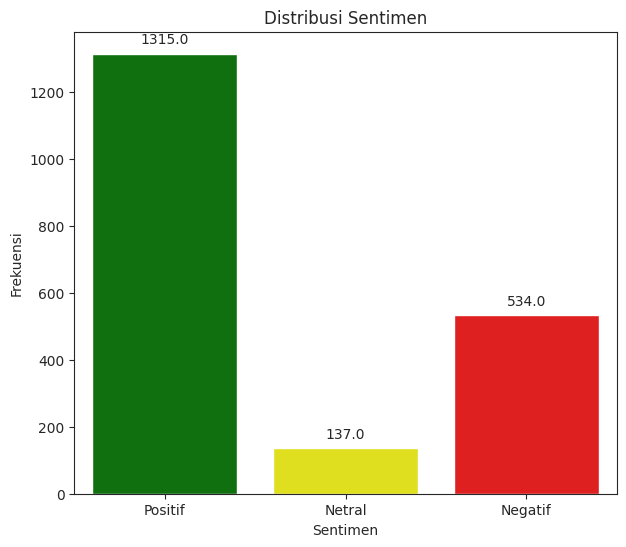

In [ ]:
plt.figure(figsize=(7, 6))
ax = sns.countplot(x='sentimen', hue='sentimen', data=sayurbox, palette={'Positif': 'green','Netral':'yellow', 'Negatif': 'red'}, legend=False)
# 'sentimen' column is assigned to both x and hue, and legend is set to False

# Loop untuk menambahkan teks di atas setiap bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Frekuensi')
plt.show()

Berdasarkan visualisasi label sentimen di atas didapatkan
- Terdapat 1315 ulasan dengan sentimen positif, 137 ulasan dengan sentimen netral, dan 534 ulasan dengan sentimen negatif.
- Jumlah ulasan sentimen positif lebih dominan dibandingkan sentimen netral dan negatif.
- Sentimen pada ulasan Sayurbox cenderung menunjukkan sentimen positif.

## Distribusi Score Aplikasi
Akan divisualisasikan ulasan Sayurbox berdasarkan score yang diberikan pengguna pada aplikasi Sayurbox.

### Bar chart

In [ ]:
#score

plt.figure(figsize=(9, 7))
ax = sns.countplot(x='score', hue='score', data=sayurbox)
# 'sentimen' column is assigned to both x and hue, and legend is set to False



# Loop untuk menambahkan teks di atas setiap bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Distribusi Score')
plt.xlabel('Score')
plt.ylabel('Frekuensi')
plt.show()

Sebelumnya didefinisikan bahwa score:
- 1 = sangat tidak puas
- 2 = tidak puas
- 3 = netral
- 4 = puas
- 5 = sangat puas

Berdasarkan visualisasi bar chart score aplikasi Sayurbox didapatkan


---


(1) Sangat Tidak Puas

Sekitar 296 pengguna yang memberikan rating "Sangat Tidak Puas". Hal ini, menunjukkan adanya sejumlah pengguna yang memiliki pengalaman yang sangat negatif dengan aplikasi Sayurbox. Penyebabnya, mungkin disebabkan oleh masalah serius terkait fungsionalitas, kualitas produk, layanan pelanggan, atau aspek lainnya yang membuat mereka sangat kecewa.

(2) Tidak Puas

Sebanyak 94 pengguna memberikan rating "Tidak Puas". Kelompok ini juga menunjukkan adanya ketidakpuasan terhadap aplikasi, meskipun mungkin tingkat kekecewaannya tidak separah kelompok "Sangat Tidak Puas".

(3) Netral

Terdapat 104 pengguna yang memberikan rating "Netral". Kelompok ini tidak memberikan penilaian positif maupun negatif yang kuat. Mereka mungkin memiliki pengalaman yang biasa saja dengan pengalaman yang tidak terlalu buruk namun juga tidak terlalu memuaskan. Bisa jadi mereka belum sepenuhnya merasakan manfaat atau potensi dari aplikasi Sayurbox.

(4) Puas

Sekitar 132 pengguna yang memberikan rating "Puas". Hal ini, menunjukkan adanya pengguna yang memiliki pengalaman positif dengan aplikasi Sayurbox. Mereka mungkin merasa puas dengan kemudahan penggunaan, kualitas produk, atau layanan yang diberikan.

(5) Sangat Puas

Jumlah pengguna yang memberikan rating "Sangat Puas" jauh lebih tinggi dibandingkan kategori lainnya, yaitu sekitar 1360 pengguna. Ini merupakan indikasi yang sangat positif bahwa sebagian besar pengguna memiliki pengalaman yang luar biasa dengan aplikasi Sayurbox. Mereka kemungkinan besar sangat terbantu dan terkesan dengan apa yang ditawarkan oleh Sayurbox.

### Score Aplikasi yearly

In [ ]:
grouped_data = sayurbox.groupby(['score', 'year']).size().reset_index(name='count')

label_mapping = {
    "Sangat Tidak Puas": 0,
    "Tidak Puas": 1,
    "Netral": 2,
    "Puas": 3,
    "Sangat Puas": 4
}

grouped_data['score'] = grouped_data['score'].map(label_mapping)

In [ ]:
#melihat observasi per tahunnya
sayurbox.groupby('year').size()

year
2021     103
2022    1261
2023     376
2024     190
2025      56
dtype: int64

Berdasarkan data ulasan pertahun, terlihat bahwa pada tahun 2022 memiliki jumlah ulasan yang paling banyak, yaitu sebanyak 1261. Dimana angka ini berkali-kali lipat (4-20 kali lipat) dibandingkan tahun-tahun lainnya.

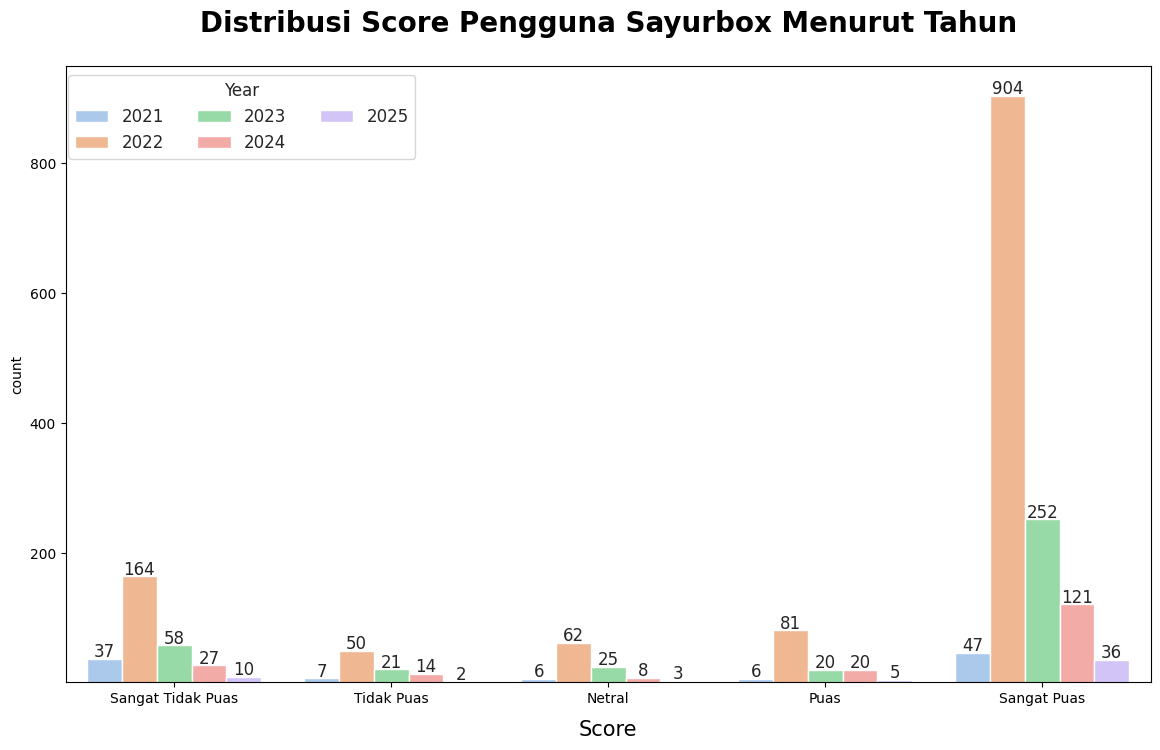

In [ ]:
# Breakdown bar chart berdasarkan tahun
fig, ax = plt.subplots(figsize=(14,8))
position = (0,1,2,3,4)
labels = ("Sangat Tidak Puas", "Tidak Puas", "Netral", "Puas", "Sangat Puas")

sns.set_style('whitegrid')
ax = sns.countplot(x="score", hue="year", data=sayurbox, palette="pastel", ax=ax)

# Tambahkan label hanya jika tinggi bar > 0
for rect in ax.patches:
    height = rect.get_height()
    if height > 0:
        ax.text(rect.get_x() + rect.get_width() / 2,
                height + 3.25,
                f'{int(height)}',
                ha='center', fontsize=12)

plt.legend(fontsize=12, bbox_to_anchor=(0.33,1), ncol=3, title="Year", title_fontsize=12)
plt.title('Distribusi Score Pengguna Sayurbox Menurut Tahun', fontsize=20,
          fontweight='bold', pad=25)
plt.xlabel('Score', fontsize=15, labelpad=10)
plt.xticks(position, labels)
plt.ylim(1)
plt.show()


Berdasarkan bar-chart pertahun, terlihat bahwa

- Lonjakan Rating di Tahun 2022: Terjadi lonjakan signifikan dalam jumlah rating pada tahun 2022 dibandingkan dengan tahun-tahun lainnya. Peningkatan ini didominasi oleh rating "Sangat Puas", yang mencapai 820 dari total 1087 rating di tahun tersebut. Ini menunjukkan bahwa pada tahun 2022, sebagian besar pengguna memberikan penilaian yang sangat positif terhadap Sayurbox.

- Penurunan Jumlah Rating Setelah 2022: Setelah lonjakan di tahun 2022, jumlah rating cenderung menurun pada tahun-tahun berikutnya (2023, 2024, dan 2025). Namun, penting untuk dicatat bahwa data tahun 2025 baru berjalan sebagian (saat ini April 2025), sehingga jumlah rating kemungkinan akan bertambah.

- Distribusi Rating yang Berbeda-beda Tiap Tahun:

  - 2021: Distribusi rating cenderung lebih merata, dengan jumlah "Sangat Tidak Puas" dan "Sangat Puas" yang cukup tinggi dibandingkan kategori lainnya.
  - 2022: Sangat didominasi oleh rating "Sangat Puas".
  - 2023: Meskipun total rating menurun cukup jauh dari 2022, proporsi rating "Sangat Puas" masih yang tertinggi, diikuti oleh "Sangat Tidak Puas".
  - 2024: Proporsi "Sangat Puas" masih dominan, namun jumlah rating di semua kategori relatif lebih rendah.
  - 2025: Dengan jumlah data yang masih sedikit, "Sangat Puas" masih menjadi yang tertinggi, diikuti oleh "Sangat Tidak Puas".
- Konsistensi Rating Positif: Meskipun jumlah total rating bervariasi, kategori "Sangat Puas" secara konsisten memiliki jumlah rating tertinggi di setiap tahun, terutama setelah tahun 2021. Ini menunjukkan bahwa mayoritas pengguna yang memberikan rating cenderung memiliki pengalaman yang sangat positif dengan Sayurbox dari waktu ke waktu.

- Perlu Diperhatikan Rating Negatif: Meskipun jumlahnya jauh lebih rendah dari rating positif, rating "Sangat Tidak Puas" dan "Tidak Puas" tetap ada di setiap tahun. Sayurbox perlu terus memantau dan menganalisis umpan balik dari pengguna dengan rating negatif untuk mengidentifikasi area perbaikan.

In [ ]:
# Step 1: Hitung total skor per tahun
score_counts = sayurbox.groupby(['year', 'score']).size().reset_index(name='count')

# Step 2: Mapping label score ke deskripsi
label_mapping = {
    1: "Sangat Tidak Puas",
    2: "Tidak Puas",
    3: "Netral",
    4: "Puas",
    5: "Sangat Puas"
}
score_counts['score_label'] = score_counts['score'].map(label_mapping)

# Step 3: Plot dengan score sebagai hue, tahun sebagai x-axis
# Gunakan palet warna kontras dari seaborn
palette_contrast = sns.color_palette('Set1')  # atau bisa coba 'tab10', 'Dark2', dll.

plt.figure(figsize=(14, 8))
sns.set_style('ticks')
ax = sns.barplot(
    data=score_counts,
    x='year', y='count', hue='score_label',
    palette=palette_contrast
)

# Tambahkan label pada batang
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=11)

# Kustomisasi tampilan
plt.title('Total Skor Pengguna Sayurbox di Setiap Tahun', fontsize=20, fontweight='bold', pad=25)
plt.xlabel('Tahun', fontsize=15)
plt.ylabel('Jumlah Responden', fontsize=15)
plt.legend(title='Kategori Skor', title_fontsize=12, fontsize=11)
plt.tight_layout()
plt.show()

<ipython-input-47-f6e279c7e29e>:20: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  ax = sns.barplot(


Dari bar chart total skor per tahun di atas terlihat bahwa:  

**Tahun 2021**
- Jumlah total responden relatif sedikit, yaitu 103.
- Kategori skor tertinggi adalah "Sangat Puas" (47 responden), menunjukkan mayoritas pengguna awal cukup puas dengan layanan Sayurbox.
- Namun tetap ada sekitar 37 responden yang merasa "Sangat Tidak Puas", mengindikasikan adanya kesan awal yang cukup beragam dari pengguna.
- Citra layanan pada 2021 bisa dikatakan campuran, namun lebih banyak yang positif.

**Tahun 2022 (Tahun Puncak)**
- Merupakan tahun dengan jumlah responden terbanyak, yaitu 1261 dan terlihat dari melonjaknya semua kategori skor.
- Skor "Sangat Puas" mencapai puncaknya dengan 904 responden, jauh melebihi tahun-tahun lainnya.
- Namun, di sisi lain, juga terjadi peningkatan tajam pada skor "Sangat Tidak Puas" (164 responden) dan kategori tidak puas lainnya. Hal ini mungkin terjadi, salah satunya akibat penambahan jumlah pengguna aplikasi sayurbox.
- Ini menunjukkan bahwa Sayurbox kemungkinan besar melakukan ekspansi besar atau perubahan signifikan (promosi, campaign, peningkatan layanan, atau perubahan sistem), yang berdampak positif bagi sebagian besar pengguna, namun negatif bagi sebagian lainnya.
- Tahun ini adalah titik kritis yang menentukan bagaimana Sayurbox dipersepsikan oleh publik secara luas.

**Tahun 2023**
- Jumlah responden menurun dibanding 2022, namun mayoritas masih berada pada kategori “Sangat Puas” (252 responden).
- Jumlah ketidakpuasan juga menurun secara signifikan, misalnya hanya 58 orang yang "Sangat Tidak Puas".
- Ini bisa ditafsirkan sebagai upaya Sayurbox menstabilkan layanan dan menjaga kepuasan meskipun skalanya sudah lebih besar dari tahun sebelumnya.
- Citra Sayurbox tetap positif, meskipun sudah tidak seimpresif tahun 2022.

**Tahun 2024**
- Jumlah responden kembali turun.
- Namun jumlah yang “Sangat Puas” (121 responden) masih menjadi mayoritas, walaupun nilainya jauh dari tahun sebelumnya.
- Indikasi ini menunjukkan Sayurbox mengalami penurunan engagement atau jangkauan survei, tapi pengalaman pengguna secara umum tetap baik.
- Kelompok yang tidak puas relatif kecil, artinya masalah besar mulai jarang terjadi.

**Tahun 2025**
- Jumlah responden paling sedikit dari semua tahun.
- Mayoritas tetap memberikan skor "Sangat Puas" (36 responden), sementara skor lainnya sangat kecil.
- Hal ini bisa disebabkan oleh berhasilnya Sayurbox mempertahankan kepuasan pelanggan, namun partisipasi dalam survei menurun. Atau, adanya penurunan aktivitas pengguna atau perhatian terhadap feedback pengguna.
- Citra tetap positif, tapi perlu ditinjau ulang dari sisi partisipasi pengguna dalam evaluasi.

**Kesimpulan**
- 2022 adalah tahun puncak baik dari sisi jumlah responden maupun polaritas opini (baik sangat puas maupun sangat tidak puas).

- Tren dari 2023 ke 2025 menunjukkan penurunan jumlah responden, namun konsistensi skor “Sangat Puas” tetap dominan, menunjukkan konsistensi kualitas layanan.

- Diperlukan evaluasi apakah penurunan jumlah responden karena survei yang tidak lagi menjangkau pengguna secara luas, atau karena menurunnya minat dan keterlibatan pelanggan.

In [ ]:
# Step 1: Hitung total skor per tahun
# Step 1: Hitung total skor per tahun
score_counts = sayurbox.groupby(['year', 'score']).size().reset_index(name='count')

# Step 2: Mapping label score ke deskripsi
label_mapping = {
    1: "Sangat Tidak Puas",
    2: "Tidak Puas",
    3: "Netral",
    4: "Puas",
    5: "Sangat Puas"
}
score_counts['score_label'] = score_counts['score'].map(label_mapping)

# Step 3: Filter data untuk tahun 2021
score_counts_2021 = score_counts[score_counts['year'] == 2021]
score_counts_2022 = score_counts[score_counts['year'] == 2022]
score_counts_2023 = score_counts[score_counts['year'] == 2023]
score_counts_2024 = score_counts[score_counts['year'] == 2024]
score_counts_2025 = score_counts[score_counts['year'] == 2025]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping warna dan urutan kategori
palette_custom = {
    "Sangat Tidak Puas": "#d73027",
    "Tidak Puas": "#fc8d59",
    "Netral": "#fee08b",
    "Puas": "#91cf60",
    "Sangat Puas": "#1a9850"
}
score_order = ["Sangat Tidak Puas", "Tidak Puas", "Netral", "Puas", "Sangat Puas"]

# Plot
plt.figure(figsize=(8, 6))
sns.set_style('ticks')

# Barplot dengan hue agar warnanya sesuai, tapi matikan legend default
ax = sns.barplot(
    data=score_counts_2021,
    x='score_label', y='count',
    hue='score_label',         # hue berdasarkan label skor
    palette=palette_custom,    # gunakan warna kustom
    order=score_order,         # urutkan label sesuai skala 1–5
    dodge=False,               # batang tidak berdempet (karena hanya 1 tahun)
    legend=False               # matikan legend bawaan seaborn
)

# Tambahkan label angka di atas batang
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=11)

# Tambahkan legend manual agar sesuai warna
handles = [plt.Rectangle((0, 0), 1, 1, color=palette_custom[label]) for label in score_order]
plt.legend(handles, score_order, title="Kategori Skor", title_fontsize=12, fontsize=11)

# Judul dan label sumbu
plt.title('Total Skor Pengguna Sayurbox di Tahun 2021', fontsize=20, fontweight='bold', pad=25)
plt.xlabel('Kategori Skor', fontsize=15)
plt.ylabel('Jumlah Responden', fontsize=15)
plt.tight_layout()
plt.show()

Grafik batang ini menunjukkan total skor pengguna Sayurbox di tahun 2021 berdasarkan kategori kepuasan. Sebagian besar responden (47 orang) merasa "Sangat Puas" dengan Sayurbox. Jumlah responden yang merasa "Sangat Tidak Puas" juga cukup tinggi, yaitu 37 orang. Sementara itu, jumlah responden yang memilih kategori "Tidak Puas", "Netral", dan "Puas" relatif lebih sedikit, masing-masing 7, 6, dan 6 orang.

Secara keseluruhan, terlihat adanya polarisasi pendapat di antara pengguna Sayurbox pada tahun 2021, dengan sebagian besar sangat puas dan sebagian lainnya sangat tidak puas. Kelompok dengan tingkat kepuasan di tengah cenderung lebih kecil.

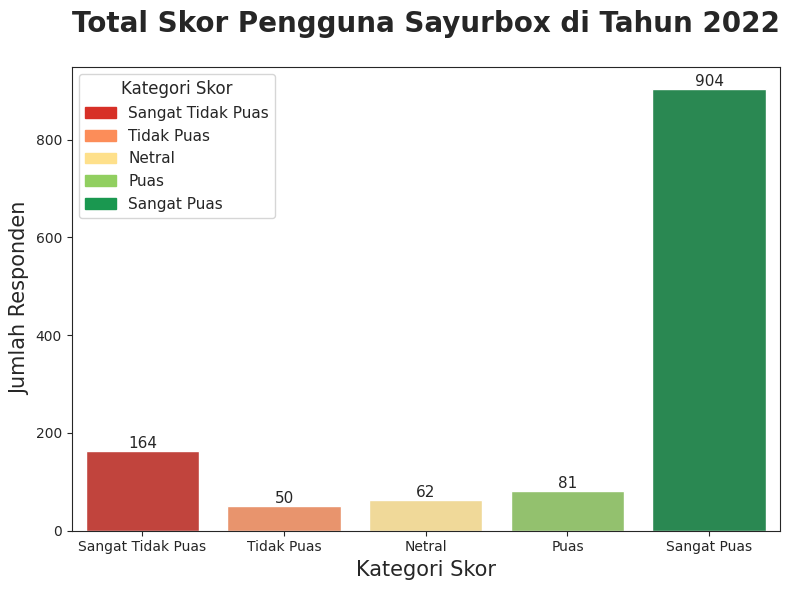

In [ ]:
# Mapping warna dan urutan kategori
palette_custom = {
    "Sangat Tidak Puas": "#d73027",
    "Tidak Puas": "#fc8d59",
    "Netral": "#fee08b",
    "Puas": "#91cf60",
    "Sangat Puas": "#1a9850"
}
score_order = ["Sangat Tidak Puas", "Tidak Puas", "Netral", "Puas", "Sangat Puas"]

# Plot
plt.figure(figsize=(8, 6))
sns.set_style('ticks')

# Barplot dengan hue agar warnanya sesuai, tapi matikan legend default
ax = sns.barplot(
    data=score_counts_2022,
    x='score_label', y='count',
    hue='score_label',         # hue berdasarkan label skor
    palette=palette_custom,    # gunakan warna kustom
    order=score_order,         # urutkan label sesuai skala 1–5
    dodge=False,               # batang tidak berdempet (karena hanya 1 tahun)
    legend=False               # matikan legend bawaan seaborn
)

# Tambahkan label angka di atas batang
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=11)

# Tambahkan legend manual agar sesuai warna
handles = [plt.Rectangle((0, 0), 1, 1, color=palette_custom[label]) for label in score_order]
plt.legend(handles, score_order, title="Kategori Skor", title_fontsize=12, fontsize=11)

# Judul dan label sumbu
plt.title('Total Skor Pengguna Sayurbox di Tahun 2022', fontsize=20, fontweight='bold', pad=25)
plt.xlabel('Kategori Skor', fontsize=15)
plt.ylabel('Jumlah Responden', fontsize=15)
plt.tight_layout()
plt.show()

Grafik batang ini menampilkan total skor pengguna Sayurbox pada tahun 2022 berdasarkan tingkat kepuasan. Terlihat lonjakan signifikan pada kategori "Sangat Puas", dengan 904 responden. Jumlah responden pada kategori lainnya jauh lebih rendah: 164 orang "Sangat Tidak Puas", 50 orang "Tidak Puas", 62 orang "Netral", dan 81 orang "Puas".


Dibandingkan tahun 2021, pada tahun 2022 terjadi peningkatan drastis jumlah pengguna yang merasa "Sangat Puas". Meskipun masih ada sejumlah responden yang "Sangat Tidak Puas", proporsinya jauh lebih kecil dibandingkan dengan kelompok "Sangat Puas". Ini menunjukkan adanya pergeseran besar ke arah kepuasan yang tinggi di antara pengguna Sayurbox pada tahun 2022.

In [ ]:
# Mapping warna dan urutan kategori
palette_custom = {
    "Sangat Tidak Puas": "#d73027",
    "Tidak Puas": "#fc8d59",
    "Netral": "#fee08b",
    "Puas": "#91cf60",
    "Sangat Puas": "#1a9850"
}
score_order = ["Sangat Tidak Puas", "Tidak Puas", "Netral", "Puas", "Sangat Puas"]

# Plot
plt.figure(figsize=(8, 6))
sns.set_style('ticks')

# Barplot dengan hue agar warnanya sesuai, tapi matikan legend default
ax = sns.barplot(
    data=score_counts_2023,
    x='score_label', y='count',
    hue='score_label',         # hue berdasarkan label skor
    palette=palette_custom,    # gunakan warna kustom
    order=score_order,         # urutkan label sesuai skala 1–5
    dodge=False,               # batang tidak berdempet (karena hanya 1 tahun)
    legend=False               # matikan legend bawaan seaborn
)

# Tambahkan label angka di atas batang
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=11)

# Tambahkan legend manual agar sesuai warna
handles = [plt.Rectangle((0, 0), 1, 1, color=palette_custom[label]) for label in score_order]
plt.legend(handles, score_order, title="Kategori Skor", title_fontsize=12, fontsize=11)

# Judul dan label sumbu
plt.title('Total Skor Pengguna Sayurbox di Tahun 2023', fontsize=20, fontweight='bold', pad=25)
plt.xlabel('Kategori Skor', fontsize=15)
plt.ylabel('Jumlah Responden', fontsize=15)
plt.tight_layout()
plt.show()

Grafik batang ini menyajikan total skor pengguna Sayurbox pada tahun 2023 berdasarkan kategori kepuasan. Mayoritas responden (252 orang) menyatakan "Sangat Puas". Jumlah responden untuk kategori lainnya adalah sebagai berikut: 58 orang "Sangat Tidak Puas", 21 orang "Tidak Puas", 25 orang "Netral", dan 20 orang "Puas".

Jika dibandingkan dengan tahun 2022, jumlah responden yang "Sangat Puas" mengalami penurunan yang signifikan, meskipun masih menjadi yang terbesar. Jumlah responden di kategori "Sangat Tidak Puas" juga menurun. Sementara itu, jumlah responden pada kategori "Tidak Puas", "Netral", dan "Puas" juga relatif kecil. Secara keseluruhan, meskipun jumlah pengguna yang sangat puas menurun, kategori ini masih mendominasi respons pada tahun 2023.

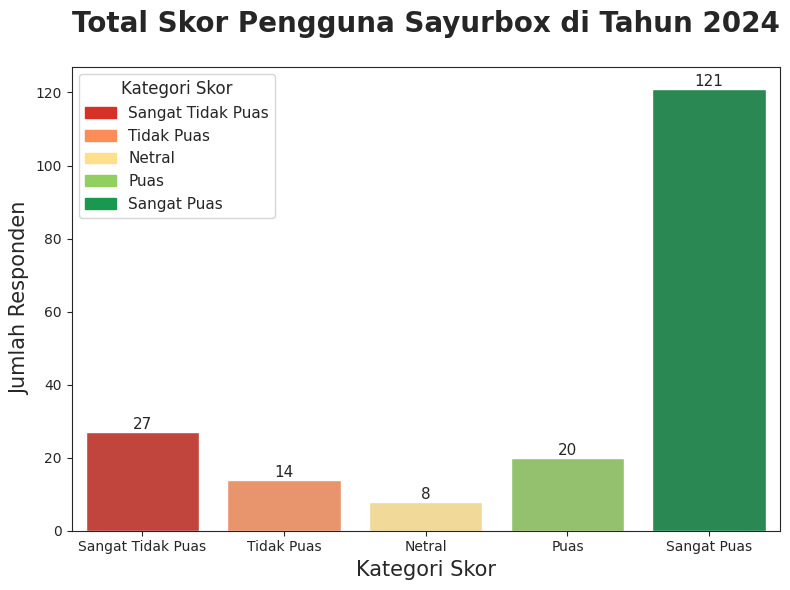

In [ ]:
# Mapping warna dan urutan kategori
palette_custom = {
    "Sangat Tidak Puas": "#d73027",
    "Tidak Puas": "#fc8d59",
    "Netral": "#fee08b",
    "Puas": "#91cf60",
    "Sangat Puas": "#1a9850"
}
score_order = ["Sangat Tidak Puas", "Tidak Puas", "Netral", "Puas", "Sangat Puas"]

# Plot
plt.figure(figsize=(8, 6))
sns.set_style('ticks')

# Barplot dengan hue agar warnanya sesuai, tapi matikan legend default
ax = sns.barplot(
    data=score_counts_2024,
    x='score_label', y='count',
    hue='score_label',         # hue berdasarkan label skor
    palette=palette_custom,    # gunakan warna kustom
    order=score_order,         # urutkan label sesuai skala 1–5
    dodge=False,               # batang tidak berdempet (karena hanya 1 tahun)
    legend=False               # matikan legend bawaan seaborn
)

# Tambahkan label angka di atas batang
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=11)

# Tambahkan legend manual agar sesuai warna
handles = [plt.Rectangle((0, 0), 1, 1, color=palette_custom[label]) for label in score_order]
plt.legend(handles, score_order, title="Kategori Skor", title_fontsize=12, fontsize=11)

# Judul dan label sumbu
plt.title('Total Skor Pengguna Sayurbox di Tahun 2024', fontsize=20, fontweight='bold', pad=25)
plt.xlabel('Kategori Skor', fontsize=15)
plt.ylabel('Jumlah Responden', fontsize=15)
plt.tight_layout()
plt.show()

Grafik batang ini menggambarkan total skor pengguna Sayurbox pada tahun 2024 berdasarkan tingkat kepuasan. Kategori "Sangat Puas" masih mendominasi dengan 121 responden. Jumlah responden untuk kategori lainnya adalah: 27 orang "Sangat Tidak Puas", 14 orang "Tidak Puas", 8 orang "Netral", dan 20 orang "Puas".

Dibandingkan tahun 2023, jumlah responden yang "Sangat Puas" kembali mengalami penurunan. Penurunan juga terlihat pada kategori "Sangat Tidak Puas" dan "Tidak Puas". Sementara itu, kategori "Netral" tetap memiliki jumlah responden yang paling sedikit. Meskipun terjadi penurunan, kategori "Sangat Puas" masih menjadi yang terbesar di antara pengguna Sayurbox pada tahun 2024.

In [ ]:
# Mapping warna dan urutan kategori
palette_custom = {
    "Sangat Tidak Puas": "#d73027",
    "Tidak Puas": "#fc8d59",
    "Netral": "#fee08b",
    "Puas": "#91cf60",
    "Sangat Puas": "#1a9850"
}
score_order = ["Sangat Tidak Puas", "Tidak Puas", "Netral", "Puas", "Sangat Puas"]

# Plot
plt.figure(figsize=(8, 6))
sns.set_style('ticks')

# Barplot dengan hue agar warnanya sesuai, tapi matikan legend default
ax = sns.barplot(
    data=score_counts_2025,
    x='score_label', y='count',
    hue='score_label',         # hue berdasarkan label skor
    palette=palette_custom,    # gunakan warna kustom
    order=score_order,         # urutkan label sesuai skala 1–5
    dodge=False,               # batang tidak berdempet (karena hanya 1 tahun)
    legend=False               # matikan legend bawaan seaborn
)

# Tambahkan label angka di atas batang
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=11)

# Tambahkan legend manual agar sesuai warna
handles = [plt.Rectangle((0, 0), 1, 1, color=palette_custom[label]) for label in score_order]
plt.legend(handles, score_order, title="Kategori Skor", title_fontsize=12, fontsize=11)

# Judul dan label sumbu
plt.title('Total Skor Pengguna Sayurbox di Tahun 2025', fontsize=20, fontweight='bold', pad=25)
plt.xlabel('Kategori Skor', fontsize=15)
plt.ylabel('Jumlah Responden', fontsize=15)
plt.tight_layout()
plt.show()

Grafik batang ini menunjukkan total skor pengguna Sayurbox pada tahun 2025 berdasarkan kategori kepuasan. Kategori "Sangat Puas" masih menjadi yang terbanyak dengan 36 responden. Jumlah responden untuk kategori lainnya adalah: 10 orang "Sangat Tidak Puas", 2 orang "Tidak Puas", 3 orang "Netral", dan 5 orang "Puas".

Dibandingkan tahun 2024, jumlah responden di semua kategori mengalami penurunan. Penurunan paling signifikan terjadi pada kategori "Sangat Puas". Meskipun demikian, kategori ini tetap mendominasi respons pengguna Sayurbox pada tahun 2025, diikuti oleh kategori "Sangat Tidak Puas". Jumlah responden pada kategori "Tidak Puas" dan "Netral" sangat sedikit.

### Line Chart

In [ ]:
plt.figure(figsize=(14, 8))
sns.set_style("ticks")

# Plot line
sns.lineplot(
    data=score_counts,
    x='year', y='count',
    hue='score_label',
    style='score_label',
    dashes=True,
    marker='o',
    palette='tab10'  # Ganti warna jadi lebih kontras
)

# Menambahkan angka di atas setiap titik
for year in score_counts['year'].unique():
    # Ambil data yang sesuai dengan tahun
    year_data = score_counts[score_counts['year'] == year]

    for i, row in year_data.iterrows():
        plt.text(
            row['year'], row['count'],  # Posisi x dan y untuk teks
            str(row['count']),  # Angka yang ditampilkan
            color='black',  # Warna teks
            ha='center',  # Horizontal alignment (center di atas titik)
            va='bottom',  # Vertical alignment (posisi teks di atas titik)
            fontsize=10  # Ukuran font
        )

# Kustomisasi tampilan
plt.title('Perkembangan Jumlah Tiap Kategori Skor Pengguna Sayurbox per Tahun', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Tahun', fontsize=15)
plt.ylabel('Jumlah Responden', fontsize=15)
plt.legend(title='Kategori Skor', title_fontsize=12, fontsize=11)
plt.xticks(score_counts['year'].unique())
plt.tight_layout()
plt.show()

## Dsitribusi AppVersion

### Pie-chart

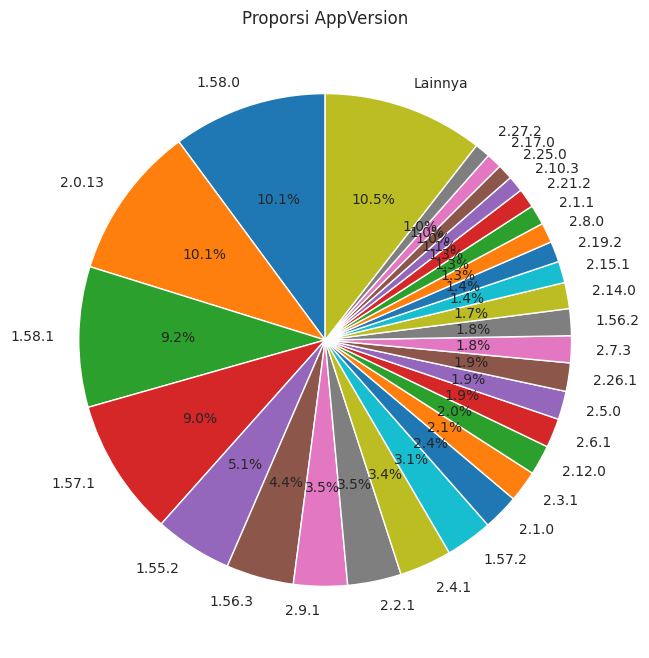

In [ ]:
app_version_counts = sayurbox['appVersion'].value_counts()
total_counts = app_version_counts.sum()
threshold = 0.01  # Batas proporsi 1%

# Filter appVersion yang di bawah threshold
filtered_counts = app_version_counts[app_version_counts / total_counts >= threshold]

# Gabungkan appVersion yang di bawah threshold menjadi 'Lainnya'
other_counts = app_version_counts[app_version_counts / total_counts < threshold].sum()
filtered_counts['Lainnya'] = other_counts

plt.figure(figsize=(8, 8))
plt.pie(filtered_counts, labels=filtered_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Proporsi AppVersion')
plt.show()

### Bar chart by Jumlah Ulasan tiap AppVersion

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Atur ukuran plot
sns.countplot(x='appVersion', data=sayurbox, order=sayurbox['appVersion'].value_counts().index)  # Urutkan berdasarkan frekuensi
plt.xticks(rotation=90)  # Rotasi label sumbu x agar mudah dibaca
plt.title('Distribusi AppVersion')
plt.xlabel('AppVersion')
plt.ylabel('Jumlah Ulasan')
plt.show()

### Mean Sentimen dari AppVersion

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def sentiment_numeric(sentiment):
    if sentiment == 'Positif':
        return 1
    elif sentiment == 'Netral':
        return 0
    elif sentiment == 'Negatif':
        return -1
    else:
        return np.nan  # atau nilai lain yang sesuai jika ada sentimen lain

# Terapkan fungsi sentiment_numeric untuk membuat kolom sentiment_numeric
sayurbox['sentiment_numeric'] = sayurbox['sentimen'].apply(sentiment_numeric)

# Filter data untuk versi aplikasi yang diinginkan
selected_versions = ['2.0.13', '1.58.0', '1.58.1', '1.57.1', '1.55.2']
filtered_sayurbox = sayurbox[sayurbox['appVersion'].isin(selected_versions)]

# Hitung mean sentiment untuk setiap versi aplikasi
mean_sentiments = filtered_sayurbox.groupby('appVersion')['sentiment_numeric'].mean()

# Buat plot bar
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=mean_sentiments.index, y=mean_sentiments.values)
plt.title('Mean Sentiment untuk Versi Aplikasi Tertentu')
plt.xlabel('Versi Aplikasi')
plt.ylabel('Mean Sentiment')
plt.ylim([-1, 1])  # Batasi sumbu y dari -1 hingga 1

# Tambahkan nilai di atas setiap bar
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, color='black', xytext=(0, 8),
                   textcoords='offset points')

plt.show()

## Wordcloud per appversion

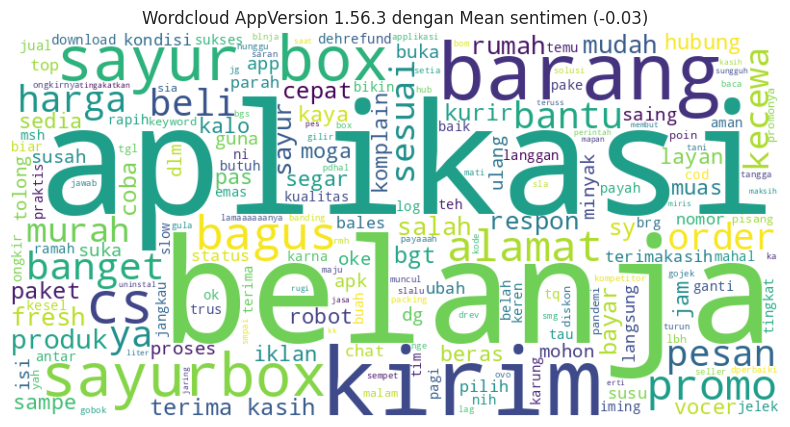

In [ ]:
app_version_1571 = sayurbox[sayurbox['appVersion'] == '1.57.1']['content'].astype(str)
app_version_1563 = sayurbox[sayurbox['appVersion'] == '1.56.3']['content'].astype(str)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Wordcloud untuk appVersion 1.57.1
wordcloud_1571 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(app_version_1571))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1571, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud AppVersion 1.57.1 dengan Mean sentimen (0.72)')
plt.show()

# Wordcloud untuk appVersion 1.56.3
wordcloud_1563 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(app_version_1563))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1563, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud AppVersion 1.56.3 dengan Mean sentimen (-0.03)')
plt.show()

## Wordcloud per sentimen

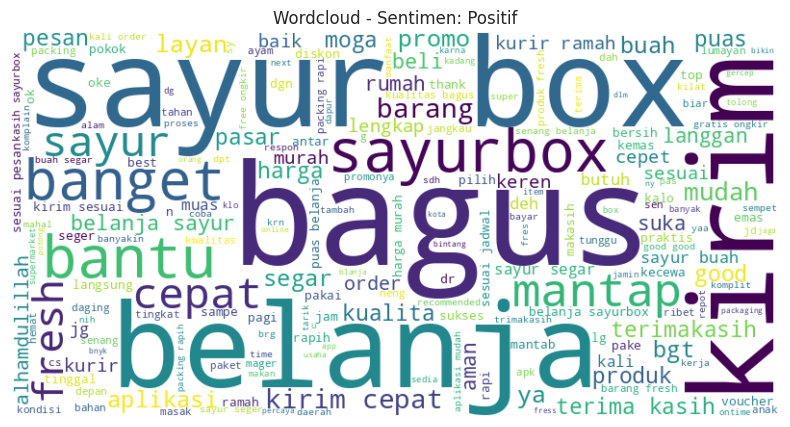

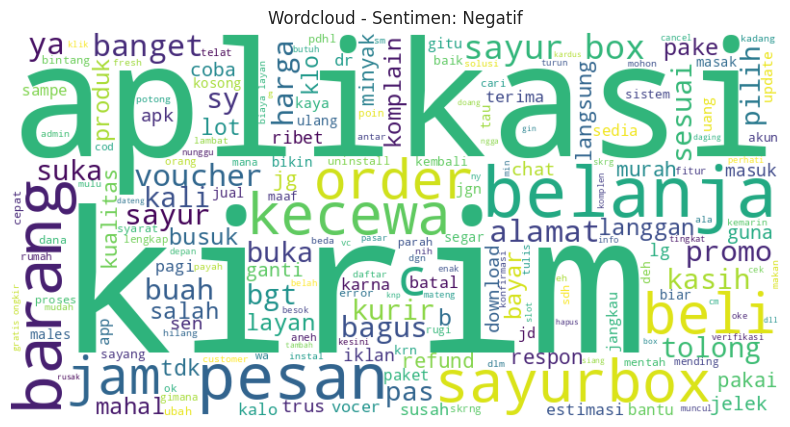

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for label in sayurbox['sentimen'].unique():
    text = ' '.join(sayurbox[sayurbox['sentimen'] == label]['content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud - Sentimen: {label}')
    plt.show()


## Common word
Menunjukkan 20 kata yang paling sering muncul dalam ulasan.

###All sentimen

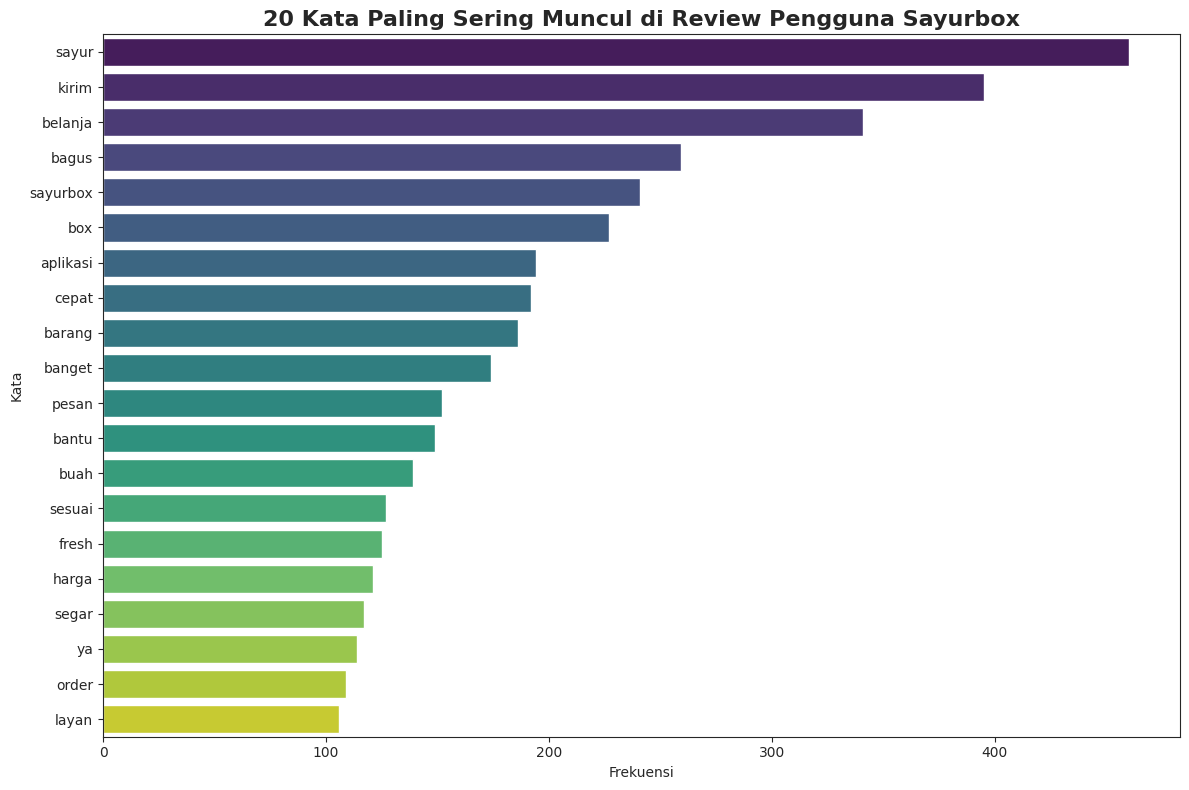

In [ ]:
# ubah semua ke string (jaga-jaga)
sayurbox['content'] = sayurbox['content'].astype(str)

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# inisialisasi vectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sayurbox['content'])

# jumlahkan frekuensi setiap kata
word_freq = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()
freq_df = pd.DataFrame({'word': words, 'freq': word_freq})

# ambil 20 kata paling sering
top_n = 20
top_words = freq_df.sort_values(by='freq', ascending=False).head(top_n)

# plot horizontal barplot
plt.figure(figsize=(12, 8))
sns.barplot(x='freq', y='word', hue='word', data=top_words, palette='viridis', legend=False)
plt.title(f'{top_n} Kata Paling Sering Muncul di Review Pengguna Sayurbox', fontsize=16, weight='bold')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.tight_layout()
plt.show()

Kata yang paling sering muncul adalah kata 'sayur' sejalan dengan aplikasi ini yang memang memberikan pelayanan barang atau jasa dengan sayurnya.

### Positif

<ipython-input-139-db5c4c2cb30b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sayurbox_positif['content'] = sayurbox_positif['content'].astype(str)


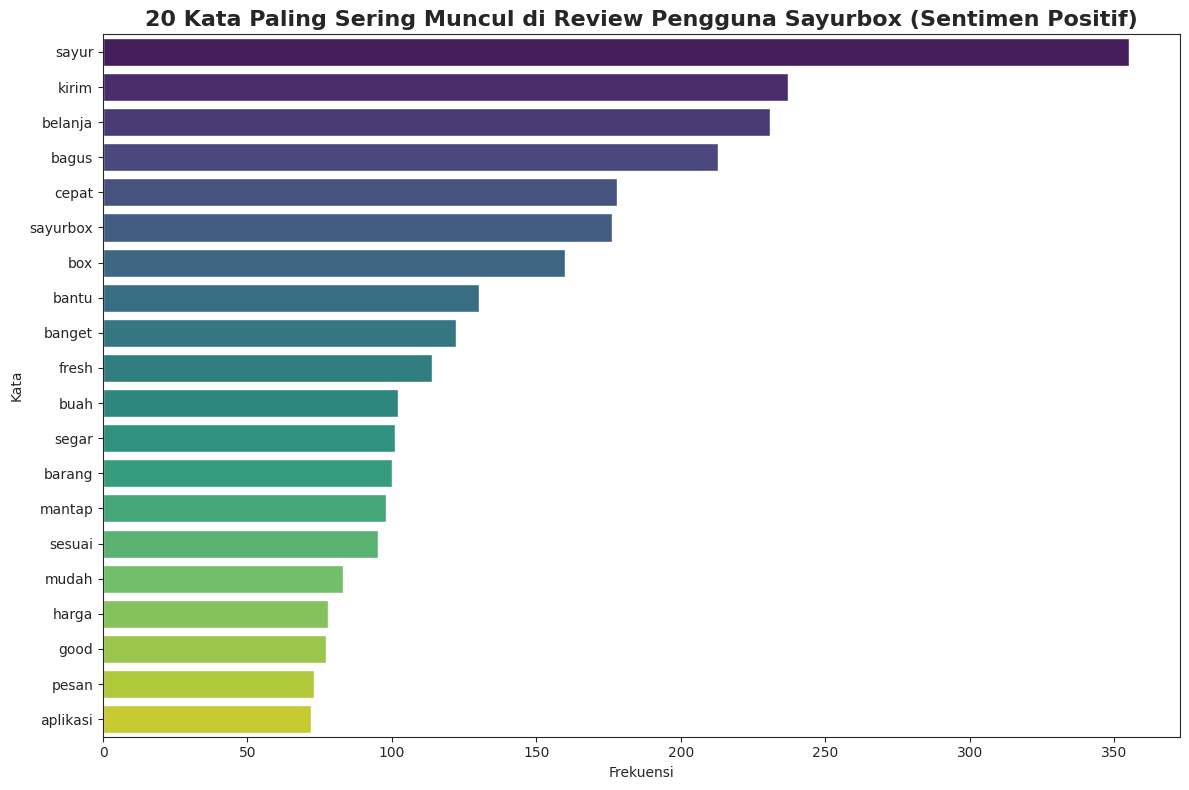

In [ ]:
# Filter dataframe untuk sentimen positif
sayurbox_positif = sayurbox[sayurbox['sentimen'] == 'Positif']

# Ubah semua ke string (jaga-jaga)
sayurbox_positif['content'] = sayurbox_positif['content'].astype(str)

# Inisialisasi vectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sayurbox_positif['content'])

# Jumlahkan frekuensi setiap kata
word_freq = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()
freq_df = pd.DataFrame({'word': words, 'freq': word_freq})

# Ambil 20 kata paling sering
top_n = 20
top_words = freq_df.sort_values(by='freq', ascending=False).head(top_n)

# Plot horizontal barplot
plt.figure(figsize=(12, 8))
sns.barplot(x='freq', y='word', hue='word', data=top_words, palette='viridis', legend=False)
plt.title(f'{top_n} Kata Paling Sering Muncul di Review Pengguna Sayurbox (Sentimen Positif)', fontsize=16, weight='bold')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.tight_layout()
plt.show()

kata terbanyak yang ada pada sentimen positif adalah kata 'sayur'

### Netral

In [ ]:
# Filter dataframe untuk sentimen netral
sayurbox_netral = sayurbox[sayurbox['sentimen'] == 'Netral']

# Ubah semua ke string (jaga-jaga)
sayurbox_netral['content'] = sayurbox_netral['content'].astype(str)

# Inisialisasi vectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sayurbox_netral['content'])

# Jumlahkan frekuensi setiap kata
word_freq = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()
freq_df = pd.DataFrame({'word': words, 'freq': word_freq})

# Ambil 20 kata paling sering
top_n = 20
top_words = freq_df.sort_values(by='freq', ascending=False).head(top_n)

# Plot horizontal barplot
plt.figure(figsize=(12, 8))
sns.barplot(x='freq', y='word', hue='word', data=top_words, palette='viridis', legend=False)
plt.title(f'{top_n} Kata Paling Sering Muncul di Review Pengguna Sayurbox (Sentimen Netral)', fontsize=16, weight='bold')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.tight_layout()
plt.show()

<ipython-input-140-e5ec29fa52d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sayurbox_netral['content'] = sayurbox_netral['content'].astype(str)


kata terbanyak pada ulasan sentimen netral adalah kata 'ok'

### Negatif

<ipython-input-141-23a6a658fc49>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sayurbox_negatife['content'] = sayurbox_negatife['content'].astype(str)


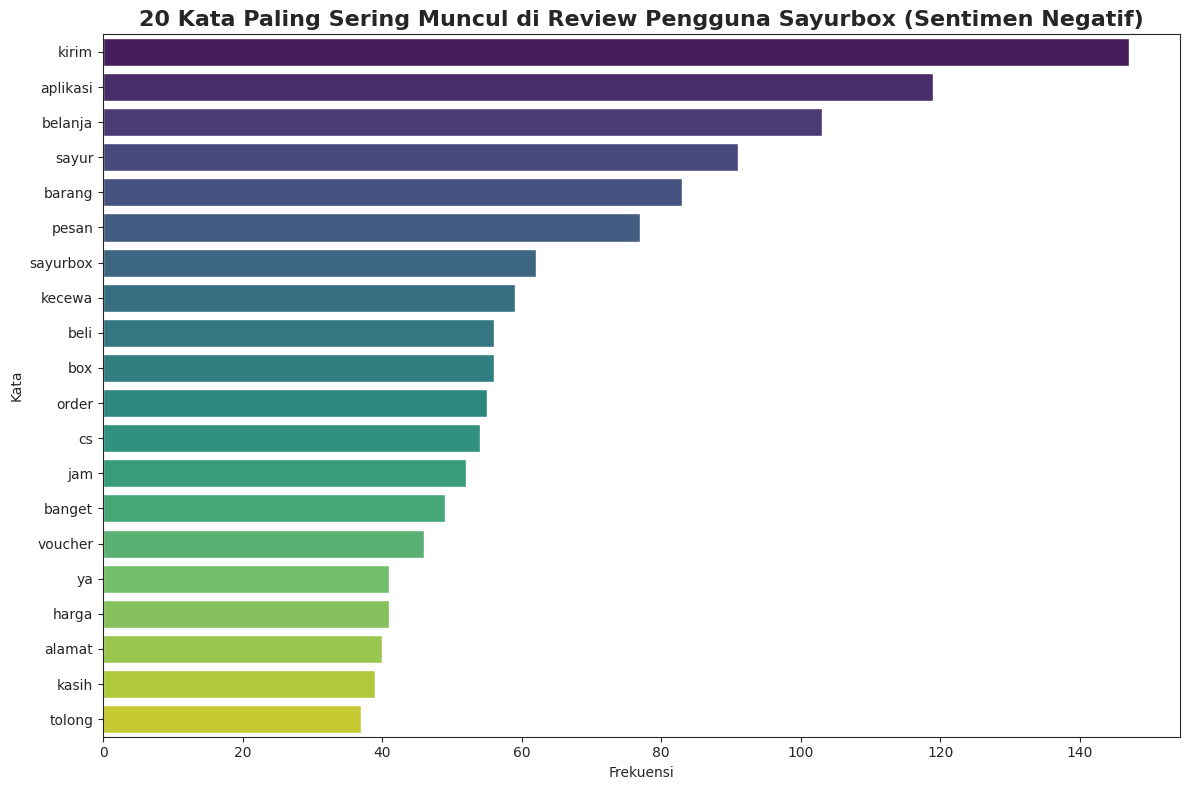

In [ ]:
# Filter dataframe untuk sentimen negatif
sayurbox_negatife = sayurbox[sayurbox['sentimen'] == 'Negatif']

# Ubah semua ke string (jaga-jaga)
sayurbox_negatife['content'] = sayurbox_negatife['content'].astype(str)

# Inisialisasi vectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sayurbox_negatife['content'])

# Jumlahkan frekuensi setiap kata
word_freq = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()
freq_df = pd.DataFrame({'word': words, 'freq': word_freq})

# Ambil 20 kata paling sering
top_n = 20
top_words = freq_df.sort_values(by='freq', ascending=False).head(top_n)

# Plot horizontal barplot
plt.figure(figsize=(12, 8))
sns.barplot(x='freq', y='word', hue='word', data=top_words, palette='viridis', legend=False)
plt.title(f'{top_n} Kata Paling Sering Muncul di Review Pengguna Sayurbox (Sentimen Negatif)', fontsize=16, weight='bold')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.tight_layout()
plt.show()

# INDO BERT (P1 VS P2) - DONE :)

**KALAU MAU RUN PAKE GPU YA GES**

In [ ]:
!git clone https://github.com/ezaaputra/indonlu.git

!pip install emoji
!pip install transformers

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

Cloning into 'indonlu'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 460 (delta 119), reused 108 (delta 108), pack-reused 312 (from 1)
Receiving objects: 100% (460/460), 4.83 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (229/229), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 27.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Splitting Data (70:20:10)

In [ ]:
# Membuat dataset untuk modeling dengan BERT
df = sayurbox[['normalization', 'sentimen']].rename(columns={'normalization': 'content'})
df.head()

content sentimen
0  sangat praktis dan harga nya pun masih terjang...  Positif
1    terima kasih, paket sudah diterima dengan baik.  Positif
2  trìmakasih.. memudahkan saya dalam membeli say...  Positif
3              senang belanja di sini.. semua segar.  Positif
4                                       terima kasih   Netral

In [ ]:
# Rename kolom agar konsisten dengan referensi (opsional)
df_v2 = df.rename(columns={'content': 'text', 'sentimen': 'category'})

# Terjemahkan label kategori ke format Inggris agar cocok dengan LABEL2INDEX
df_v2['category'] = df_v2['category'].replace({
    'Positif': 'positive',
    'Negatif': 'negative',
    'Netral': 'neutral'
})

# Split data: 70% train, 20% val, 10% test
train_set, val_set = train_test_split(
    df_v2,
    test_size=0.3,
    stratify=df_v2['category'],
    random_state=1
)

val_set, test_set = train_test_split(
    val_set,
    test_size=0.33,
    stratify=val_set['category'],
    random_state=1
)

# Simpan ke file .tsv di folder /content/ (lokasi default Colab)
train_path = "/content/train_set.tsv"
val_path = "/content/val_set.tsv"
test_path = "/content/test_set.tsv"

train_set.to_csv(train_path, sep='\t', header=None, index=False)
val_set.to_csv(val_path, sep='\t', header=None, index=False)
test_set.to_csv(test_path, sep='\t', header=None, index=False)

print("✅ Dataset berhasil disimpan ke:")
print(f"- Train: {train_path}")
print(f"- Validation: {val_path}")
print(f"- Test: {test_path}")

✅ Dataset berhasil disimpan ke:
- Train: /content/train_set.tsv
- Validation: /content/val_set.tsv
- Test: /content/test_set.tsv


### Distribusi Data Train, Val, & Test

In [ ]:
# Load data train
train_df = pd.read_csv('/content/train_set.tsv', sep='\t', header=None, names=['text', 'category'])

# Hitung distribusi label
label_counts = train_df['category'].value_counts()

# Cetak jumlah total data dan distribusi label
print(f"Jumlah total data di dataset train: {len(train_df)}")
print("Distribusi label di dataset train:")
print(label_counts)

Jumlah total data di dataset train: 1390
Distribusi label di dataset train:
category
positive    920
negative    374
neutral      96
Name: count, dtype: int64


In [ ]:
# Load data validasi
val_df = pd.read_csv('/content/val_set.tsv', sep='\t', header=None, names=['text', 'category'])

# Hitung distribusi label
label_counts = val_df['category'].value_counts()

# Cetak jumlah total data dan distribusi label
print(f"Jumlah total data di dataset validasi: {len(val_df)}")
print("Distribusi label di dataset validasi:")
print(label_counts)

Jumlah total data di dataset validasi: 399
Distribusi label di dataset validasi:
category
positive    264
negative    107
neutral      28
Name: count, dtype: int64


In [ ]:
# Load data test
test_df = pd.read_csv('/content/test_set.tsv', sep='\t', header=None, names=['text', 'category'])

# Hitung distribusi label
label_counts = test_df['category'].value_counts()

# Cetak jumlah total data dan distribusi label
print(f"Jumlah total data di dataset test: {len(test_df)}")
print("Distribusi label di dataset test:")
print(label_counts)

Jumlah total data di dataset test: 197
Distribusi label di dataset test:
category
positive    131
negative     53
neutral      13
Name: count, dtype: int64


## Common Function

In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

# Set random seed
set_seed(27)

## [MODEL INDOBERT P1]

### Load Model (P1)

In [ ]:
# Load Tokenizer and Config P1
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model P1
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Struktur Model (P1)

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
count_param(model)

124443651

### Contoh hasil tokenisasi indobert p1

In [ ]:
# Load tokenizer IndoBERT-base-p1
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

# Fungsi bantu untuk menampilkan hasil tokenisasi
def print_tokenization_example(file_path, dataset_name):
    import pandas as pd

    # Baca dataset
    df = pd.read_csv(file_path, sep='\t', header=None, names=['text', 'category'])
    sample_text = df['text'].iloc[0]  # Ambil satu contoh teks
    print(f"\nContoh tokenisasi dari dataset {dataset_name}:\n")
    print(f"Teks asli       : {sample_text}\n")

    # Tokenisasi
    tokens = tokenizer.tokenize(sample_text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    decoded_text = tokenizer.decode(token_ids)

    # Tampilkan hasil
    print(f"Tokens          : {tokens}\n")
    print(f"Token IDs       : {token_ids}\n")
    print(f"Teks ter-decode : {decoded_text}\n")

# Jalankan untuk masing-masing dataset
print_tokenization_example('/content/train_set.tsv', 'Train')
print_tokenization_example('/content/val_set.tsv', 'Validation')
print_tokenization_example('/content/test_set.tsv', 'Test')


Contoh tokenisasi dari dataset Train:

Teks asli       : minyak 7500/ liter, minyak melimpah, pas dibuka tidak tersedia. kalau untuk unduh sudah saya unduh tapi kalau untuk dilanjutkan, maaf..

Tokens          : ['minyak', '750', '##0', '/', 'liter', ',', 'minyak', 'melimpah', ',', 'pas', 'dibuka', 'tidak', 'tersedia', '.', 'kalau', 'untuk', 'unduh', 'sudah', 'saya', 'unduh', 'tapi', 'kalau', 'untuk', 'dilanjutkan', ',', 'maaf', '.', '.']

Token IDs       : [2106, 17482, 30376, 30471, 5358, 30468, 2106, 13095, 30468, 280, 4594, 119, 2008, 30470, 599, 90, 14357, 259, 209, 14357, 469, 599, 90, 6321, 30468, 2727, 30470, 30470]

Teks ter-decode : minyak 7500 / liter, minyak melimpah, pas dibuka tidak tersedia. kalau untuk unduh sudah saya unduh tapi kalau untuk dilanjutkan, maaf..


Contoh tokenisasi dari dataset Validation:

Teks asli       : yey pesanan tepat waktu bawang nya semua bagus bagus

Tokens          : ['ye', '##y', 'pesanan', 'tepat', 'waktu', 'bawang', 'nya', 'semua', 'bagus

### Prepare Dataset

In [ ]:
# Dataset paths
train_dataset_path = '/content/train_set.tsv'
valid_dataset_path = '/content/val_set.tsv'
test_dataset_path = '/content/test_set.tsv'

# Load dataset
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Fine Tuning & Val & Prediksi

In [ ]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

# Training
n_epochs = 5
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss += tr_loss

        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    history['train_acc'].append(metrics['ACC'])

    # Validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss = 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        valid_loss = loss.item()
        total_loss += valid_loss

        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    history['val_acc'].append(metrics['ACC'])

# Save validation predictions
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['review_text', 'category'])
val_df['pred'] = list_hyp
val_df.to_csv('val result.csv', index=False)

# Test predictions
model.eval()
torch.set_grad_enabled(False)
pred = []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

test_df = pd.read_csv(test_dataset_path, sep='\t', names=['review_text', 'category'])
test_df['pred'] = pred
test_df.to_csv('test result.csv', index=False)

val_real = val_df.category
test_real = test_df.category
val_pred = val_df.pred
test_pred = test_df.pred

(Epoch 1) TRAIN LOSS:0.7527 LR:0.00000300: 100%|██████████| 44/44 [00:19<00:00,  2.28it/s]


(Epoch 1) TRAIN LOSS:0.7527 ACC:0.66 F1:0.39 REC:0.39 PRE:0.53 LR:0.00000300


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.8078 ACC:0.66 F1:0.46 REC:0.48 PRE:0.48:   8%|▊         | 1/13 [00:01<00:12,  1.02s/it]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: Undefine

(Epoch 1) VALID LOSS:0.5685 ACC:0.77 F1:0.48 REC:0.47 PRE:0.57


  0%|          | 0/44 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 2) TRAIN LOSS:0.4704 LR:0.00000300: 100%|██████████| 44/44 [00:17<00:00,  2.48it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(Epoch 2) TRAIN LOSS:0.4704 ACC:0.84 F1:0.56 REC:0.57 PRE:0.56 LR:0.00000300


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.5249 ACC:0.75 F1:0.54 REC:0.61 PRE:0.49:   8%|▊         | 1/13 [00:00<00:08,  1.42it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: Undefine

(Epoch 2) VALID LOSS:0.3357 ACC:0.91 F1:0.75 REC:0.71 PRE:0.94


  0%|          | 0/44 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 3) TRAIN LOSS:0.3134 LR:0.00000300: 100%|██████████| 44/44 [00:18<00:00,  2.35it/s]


(Epoch 3) TRAIN LOSS:0.3134 ACC:0.91 F1:0.77 REC:0.74 PRE:0.91 LR:0.00000300


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.2512 ACC:0.93 F1:0.84 REC:0.79 PRE:0.95: 100%|██████████| 13/13 [00:02<00:00,  5.43it/s]


(Epoch 3) VALID LOSS:0.2512 ACC:0.93 F1:0.84 REC:0.79 PRE:0.95


  0%|          | 0/44 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 4) TRAIN LOSS:0.2365 LR:0.00000300: 100%|██████████| 44/44 [00:18<00:00,  2.37it/s]


(Epoch 4) TRAIN LOSS:0.2365 ACC:0.93 F1:0.82 REC:0.79 PRE:0.89 LR:0.00000300


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.2183 ACC:0.94 F1:0.84 REC:0.81 PRE:0.91: 100%|██████████| 13/13 [00:02<00:00,  4.47it/s]


(Epoch 4) VALID LOSS:0.2183 ACC:0.94 F1:0.84 REC:0.81 PRE:0.91


  0%|          | 0/44 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 5) TRAIN LOSS:0.1943 LR:0.00000300: 100%|██████████| 44/44 [00:19<00:00,  2.24it/s]


(Epoch 5) TRAIN LOSS:0.1943 ACC:0.94 F1:0.87 REC:0.84 PRE:0.91 LR:0.00000300


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.2385 ACC:0.93 F1:0.85 REC:0.81 PRE:0.92: 100%|██████████| 13/13 [00:02<00:00,  5.20it/s]


(Epoch 5) VALID LOSS:0.2385 ACC:0.93 F1:0.85 REC:0.81 PRE:0.92


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  3.99it/s]


### Hasil Evaluasi INDOBERT P1


=== CLASSIFICATION REPORT VALIDASI: INDO-BERT P1 ===


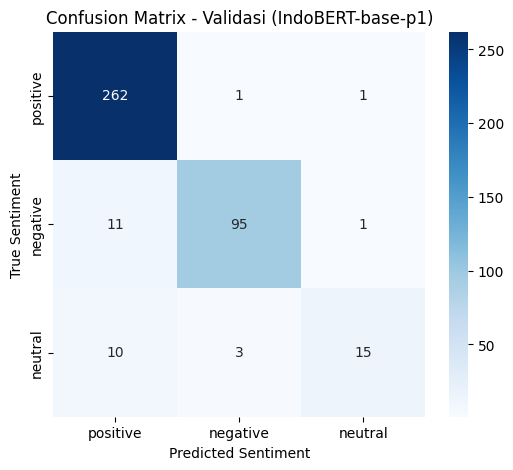

              precision    recall  f1-score   support

    positive       0.93      0.99      0.96       264
    negative       0.96      0.89      0.92       107
     neutral       0.88      0.54      0.67        28

    accuracy                           0.93       399
   macro avg       0.92      0.81      0.85       399
weighted avg       0.93      0.93      0.93       399


=== CLASSIFICATION REPORT TEST: INDO-BERT P1 ===


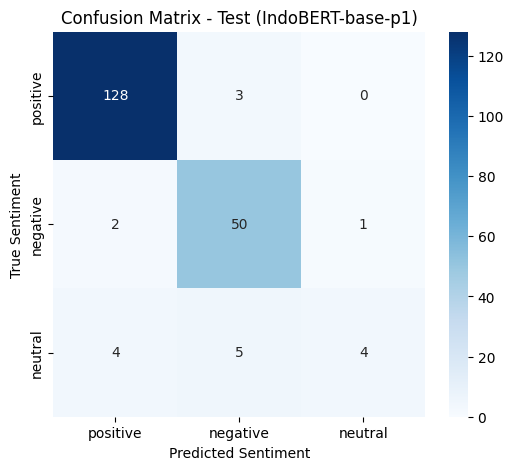

              precision    recall  f1-score   support

    positive       0.96      0.98      0.97       131
    negative       0.86      0.94      0.90        53
     neutral       0.80      0.31      0.44        13

    accuracy                           0.92       197
   macro avg       0.87      0.74      0.77       197
weighted avg       0.92      0.92      0.91       197



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Pastikan urutan labelnya sesuai distribusi dataset
labels = ['positive', 'negative', 'neutral']

# ======== PLOT AKURASI ========
epochs = range(1, len(history['train_acc']) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='o')
plt.title('Learning Curve - Accuracy (IndoBERT-base-p1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()

# ======== PLOT LOSS (jika tersedia) ========
if 'train_loss' in history and 'val_loss' in history:
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Learning Curve - Loss (IndoBERT-base-p1)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()
    plt.show()

# ======== CONFUSION MATRIX & REPORT VALIDASI ========
print("\n=== CLASSIFICATION REPORT VALIDASI: INDO-BERT P1 ===")
cm_val = confusion_matrix(val_real, val_pred, labels=labels)
df_cm_val = pd.DataFrame(cm_val, index=labels, columns=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm_val, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Validasi (IndoBERT-base-p1)")
plt.ylabel("True Sentiment")
plt.xlabel("Predicted Sentiment")
plt.show()

print(classification_report(val_real, val_pred, labels=labels, target_names=labels))

# ======== CONFUSION MATRIX & REPORT TEST ========
print("\n=== CLASSIFICATION REPORT TEST: INDO-BERT P1 ===")
cm_test = confusion_matrix(test_real, test_pred, labels=labels)
df_cm_test = pd.DataFrame(cm_test, index=labels, columns=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test (IndoBERT-base-p1)")
plt.ylabel("True Sentiment")
plt.xlabel("Predicted Sentiment")
plt.show()

print(classification_report(test_real, test_pred, labels=labels, target_names=labels))

## [MODEL INDOBERT P2]

### Load Model (P2)

In [ ]:
# Load Tokenizer and Config P2
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p2')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model P2
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', config=config)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Struktur Model (P2)

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
count_param(model)

124443651

### Contoh hasil tokenisasi indobert p2

In [ ]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

# Fungsi bantu untuk menampilkan hasil tokenisasi
def print_tokenization_example(file_path, dataset_name):
    import pandas as pd

    # Baca dataset
    df = pd.read_csv(file_path, sep='\t', header=None, names=['text', 'category'])
    sample_text = df['text'].iloc[0]  # Ambil satu contoh teks
    print(f"\nContoh tokenisasi dari dataset {dataset_name}:\n")
    print(f"Teks asli       : {sample_text}\n")

    # Tokenisasi
    tokens = tokenizer.tokenize(sample_text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    decoded_text = tokenizer.decode(token_ids)

    # Tampilkan hasil
    print(f"Tokens          : {tokens}\n")
    print(f"Token IDs       : {token_ids}\n")
    print(f"Teks ter-decode : {decoded_text}\n")

# Jalankan untuk masing-masing dataset
print_tokenization_example('/content/train_set.tsv', 'Train')
print_tokenization_example('/content/val_set.tsv', 'Validation')
print_tokenization_example('/content/test_set.tsv', 'Test')


Contoh tokenisasi dari dataset Train:

Teks asli       : minyak 7500/ liter, minyak melimpah, pas dibuka tidak tersedia. kalau untuk unduh sudah saya unduh tapi kalau untuk dilanjutkan, maaf..

Tokens          : ['minyak', '750', '##0', '/', 'liter', ',', 'minyak', 'melimpah', ',', 'pas', 'dibuka', 'tidak', 'tersedia', '.', 'kalau', 'untuk', 'unduh', 'sudah', 'saya', 'unduh', 'tapi', 'kalau', 'untuk', 'dilanjutkan', ',', 'maaf', '.', '.']

Token IDs       : [2106, 17482, 30376, 30471, 5358, 30468, 2106, 13095, 30468, 280, 4594, 119, 2008, 30470, 599, 90, 14357, 259, 209, 14357, 469, 599, 90, 6321, 30468, 2727, 30470, 30470]

Teks ter-decode : minyak 7500 / liter, minyak melimpah, pas dibuka tidak tersedia. kalau untuk unduh sudah saya unduh tapi kalau untuk dilanjutkan, maaf..


Contoh tokenisasi dari dataset Validation:

Teks asli       : yey pesanan tepat waktu bawang nya semua bagus bagus

Tokens          : ['ye', '##y', 'pesanan', 'tepat', 'waktu', 'bawang', 'nya', 'semua', 'bagus

### Prepare Dataset

In [ ]:
# Dataset paths
train_dataset_path = '/content/train_set.tsv'
valid_dataset_path = '/content/val_set.tsv'
test_dataset_path = '/content/test_set.tsv'

# Load dataset
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Fine Tuning & Val & Prediksi

In [ ]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

# Training
n_epochs = 5
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss += tr_loss

        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) [P2] TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) [P2] TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    history['train_acc'].append(metrics['ACC'])

    # Validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss = 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        valid_loss = loss.item()
        total_loss += valid_loss

        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS [P2]:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) [P2] VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    history['val_acc'].append(metrics['ACC'])

# Save validation predictions
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['review_text', 'category'])
val_df['pred'] = list_hyp
val_df.to_csv('val_result_p2.csv', index=False)

# Test predictions
model.eval()
torch.set_grad_enabled(False)
pred = []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

test_df = pd.read_csv(test_dataset_path, sep='\t', names=['review_text', 'category'])
test_df['pred'] = pred
test_df.to_csv('test_result_p2.csv', index=False)

val_real = val_df.category
val_pred = val_df.pred
test_real = test_df.category
test_pred = test_df.pred

(Epoch 1) [P2] TRAIN LOSS:0.7363 LR:0.00000300: 100%|██████████| 44/44 [00:19<00:00,  2.27it/s]


(Epoch 1) [P2] TRAIN LOSS:0.7363 ACC:0.70 F1:0.40 REC:0.40 PRE:0.48 LR:0.00000300


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS [P2]:0.8465 ACC:0.66 F1:0.45 REC:0.48 PRE:0.44:   8%|▊         | 1/13 [00:00<00:09,  1.33it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: Und

(Epoch 1) [P2] VALID LOSS:0.5782 ACC:0.79 F1:0.50 REC:0.50 PRE:0.55


  0%|          | 0/44 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 2) [P2] TRAIN LOSS:0.4787 LR:0.00000300: 100%|██████████| 44/44 [00:19<00:00,  2.29it/s]


(Epoch 2) [P2] TRAIN LOSS:0.4787 ACC:0.84 F1:0.58 REC:0.57 PRE:0.90 LR:0.00000300


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS [P2]:0.5746 ACC:0.75 F1:0.55 REC:0.63 PRE:0.49:   8%|▊         | 1/13 [00:01<00:14,  1.18s/it]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: Und

(Epoch 2) [P2] VALID LOSS:0.3488 ACC:0.91 F1:0.75 REC:0.71 PRE:0.94


  0%|          | 0/44 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 3) [P2] TRAIN LOSS:0.3213 LR:0.00000300: 100%|██████████| 44/44 [00:19<00:00,  2.20it/s]


(Epoch 3) [P2] TRAIN LOSS:0.3213 ACC:0.90 F1:0.72 REC:0.70 PRE:0.93 LR:0.00000300


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS [P2]:0.2771 ACC:0.92 F1:0.80 REC:0.75 PRE:0.95: 100%|██████████| 13/13 [00:03<00:00,  4.31it/s]


(Epoch 3) [P2] VALID LOSS:0.2771 ACC:0.92 F1:0.80 REC:0.75 PRE:0.95


  0%|          | 0/44 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 4) [P2] TRAIN LOSS:0.2510 LR:0.00000300: 100%|██████████| 44/44 [00:20<00:00,  2.20it/s]


(Epoch 4) [P2] TRAIN LOSS:0.2510 ACC:0.92 F1:0.80 REC:0.76 PRE:0.91 LR:0.00000300


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS [P2]:0.2439 ACC:0.93 F1:0.82 REC:0.79 PRE:0.89: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


(Epoch 4) [P2] VALID LOSS:0.2439 ACC:0.93 F1:0.82 REC:0.79 PRE:0.89


  0%|          | 0/44 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 5) [P2] TRAIN LOSS:0.2019 LR:0.00000300: 100%|██████████| 44/44 [00:19<00:00,  2.21it/s]


(Epoch 5) [P2] TRAIN LOSS:0.2019 ACC:0.94 F1:0.85 REC:0.82 PRE:0.92 LR:0.00000300


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS [P2]:0.2402 ACC:0.93 F1:0.84 REC:0.80 PRE:0.91: 100%|██████████| 13/13 [00:02<00:00,  5.01it/s]


(Epoch 5) [P2] VALID LOSS:0.2402 ACC:0.93 F1:0.84 REC:0.80 PRE:0.91


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


### Hasil Evaluasi INDOBERT P2

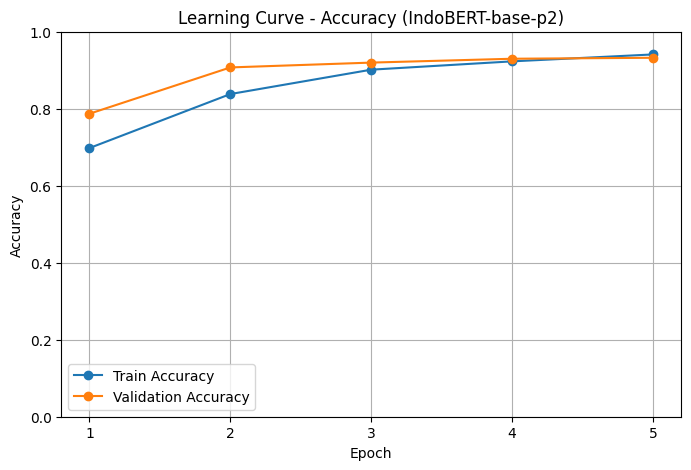


=== CLASSIFICATION REPORT VALIDASI: INDO-BERT P2 ===


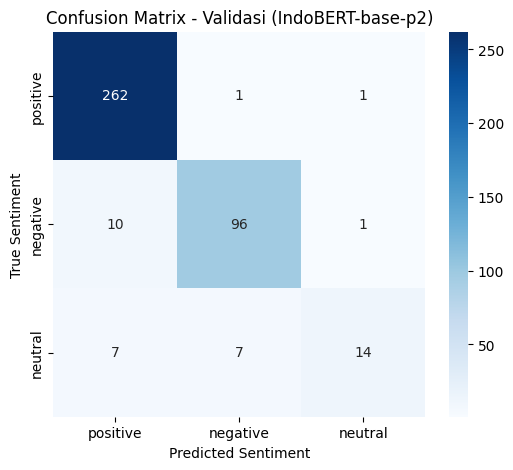

              precision    recall  f1-score   support

    positive       0.94      0.99      0.97       264
    negative       0.92      0.90      0.91       107
     neutral       0.88      0.50      0.64        28

    accuracy                           0.93       399
   macro avg       0.91      0.80      0.84       399
weighted avg       0.93      0.93      0.93       399


=== CLASSIFICATION REPORT TEST: INDO-BERT P2 ===


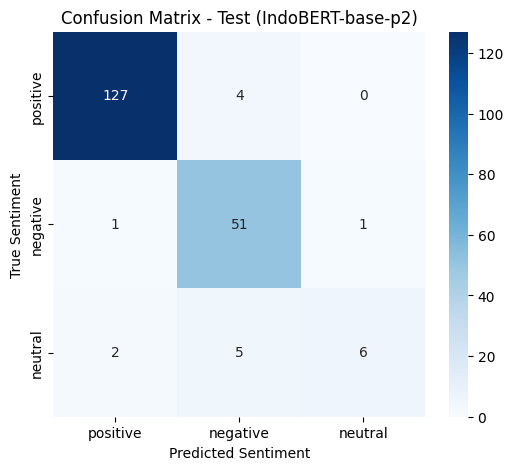

              precision    recall  f1-score   support

    positive       0.98      0.97      0.97       131
    negative       0.85      0.96      0.90        53
     neutral       0.86      0.46      0.60        13

    accuracy                           0.93       197
   macro avg       0.89      0.80      0.83       197
weighted avg       0.93      0.93      0.93       197



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Label sesuai urutan distribusi data
labels = ['positive', 'negative', 'neutral']

# ======== PLOT AKURASI ========
epochs = range(1, len(history['train_acc']) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='o')
plt.title('Learning Curve - Accuracy (IndoBERT-base-p2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()

# ======== PLOT LOSS (jika tersedia) ========
if 'train_loss' in history and 'val_loss' in history:
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Learning Curve - Loss (IndoBERT-base-p2)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()
    plt.show()

# ======== CONFUSION MATRIX & REPORT VALIDASI ========
print("\n=== CLASSIFICATION REPORT VALIDASI: INDO-BERT P2 ===")
cm_val = confusion_matrix(val_real, val_pred, labels=labels)
df_cm_val = pd.DataFrame(cm_val, index=labels, columns=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm_val, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Validasi (IndoBERT-base-p2)")
plt.ylabel("True Sentiment")
plt.xlabel("Predicted Sentiment")
plt.show()

print(classification_report(val_real, val_pred, labels=labels, target_names=labels))

# ======== CONFUSION MATRIX & REPORT TEST ========
print("\n=== CLASSIFICATION REPORT TEST: INDO-BERT P2 ===")
cm_test = confusion_matrix(test_real, test_pred, labels=labels)
df_cm_test = pd.DataFrame(cm_test, index=labels, columns=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test (IndoBERT-base-p2)")
plt.ylabel("True Sentiment")
plt.xlabel("Predicted Sentiment")
plt.show()

print(classification_report(test_real, test_pred, labels=labels, target_names=labels))